# **Chargement des librairies**

In [1]:
# ==================== Standard Libraries ====================
import os
import json
import re
import pickle
from itertools import product

# ==================== Data Manipulation ====================
import numpy as np
import pandas as pd

# ==================== Visualization ====================
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== Scikit-learn ====================
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import LabelEncoder

# ==================== Hugging Face Transformers ====================
from datasets import (Dataset, DatasetDict)
from transformers import (
    CamembertTokenizer,
    CamembertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import torch
import torch.nn as nn

# ==================== TensorFlow / Keras ====================
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Reshape, Conv2D, MaxPooling2D, Flatten,
    Dropout, Dense, Concatenate
)


# **Preparation avant modelisation**

## Charger les donnees
Les modèles de type Transformers, comme CamemBERT (pour le français) et mBERT (multilingue), n’ont pas besoin du même prétraitement que des modèles traditionnels comme TF-IDF, FastText, ou Word2Vec. En effet lors du preprocessingn, nous n'avons pas enlever les stopwords et n'avons pas fait de lemmatisation/stemming. La tokenisation est gérée par un tokenizer pré-entraîné. 

In [2]:
# Charger les fichiers CSV en ne gardant que les colonnes nécessaires
X_train = pd.read_csv("./Preprocessing/dfs/X_train_BERT.csv", usecols=["txt_fr", "prdtypecode","productid"])
X_val = pd.read_csv("./Preprocessing/dfs/X_val_BERT.csv", usecols=["txt_fr", "prdtypecode","productid"])
X_test = pd.read_csv("./Preprocessing/dfs/X_test_BERT.csv", usecols=["txt_fr", "prdtypecode","productid"])

## Rajout des labels textuels

In [3]:
labelcat = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech.",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant, déguisement",
    1281 : "Jeu de société",
    1300 : "Jouet tech",
    1301 : "Paire de chaussettes",
    1302 : "Jeu extérieur, vêtement",
    1320 : "Autour du bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues et journaux",
    2403 : "Magazines, livres et BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique et papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Autour de la piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

X_train["category_name"] = X_train["prdtypecode"].map(labelcat)
X_val["category_name"] = X_val["prdtypecode"].map(labelcat)
X_test["category_name"] = X_test["prdtypecode"].map(labelcat)

# Sauvegarde en CSV
X_train.to_csv("./Preprocessing/dfs/X_train_BERT_with_categories.csv", index=False)
X_val.to_csv("./Preprocessing/dfs/X_val_BERT_with_categories.csv", index=False)
X_test.to_csv("./Preprocessing/dfs/X_test_BERT_with_categories.csv", index=False)

## Encodage des Labels

In [4]:
# Création d'un mapping label => ID
label_mapping = {int(label): i for i, label in enumerate(sorted(X_train["prdtypecode"].unique()))}
inverse_label_mapping = {i: int(label) for label, i in label_mapping.items()}  # Convertir les labels en int

# Transformation des labels
X_train["label"] = X_train["prdtypecode"].map(label_mapping)
X_val["label"] = X_val["prdtypecode"].map(label_mapping)
X_test["label"] = X_test["prdtypecode"].map(label_mapping)

#Sauvegardes
X_train.to_csv("./Preprocessing/dfs/X_train_cam_fr_with_categories_enc.csv", index=False)
X_val.to_csv("./Preprocessing/dfs/X_val_cam_fr_with_categories_enc.csv", index=False)
X_test.to_csv("./Preprocessing/dfs/X_test_cam_fr_with_categories_enc.csv", index=False)

# Sauvegarde des mappings en JSON
with open("./Preprocessing/dfs/label_mapping.json", "w") as f:
    json.dump(label_mapping, f) 

with open("./Preprocessing/dfs/inverse_label_mapping.json", "w") as f:
    json.dump(inverse_label_mapping, f) 


## Conversion en dataset Hugging Face

In [5]:
# Conversion en Dataset Hugging Face
train_dataset = Dataset.from_pandas(X_train[["label", "txt_fr", "productid", "prdtypecode"]], preserve_index=False)
val_dataset = Dataset.from_pandas(X_val[["label", "txt_fr", "productid", "prdtypecode"]], preserve_index=False)
test_dataset = Dataset.from_pandas(X_test[["label", "txt_fr", "productid", "prdtypecode"]], preserve_index=False)

# Vérification
print(train_dataset)

Dataset({
    features: ['label', 'txt_fr', 'productid', 'prdtypecode'],
    num_rows: 66933
})


## Tokenisation avec camemBERRT

In [6]:
# Chargement du tokenizer CamemBERT
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

# Fonction de tokenisation
def tokenize_function(examples):
    return tokenizer(examples["txt_fr"], padding="max_length", truncation=True, max_length=512)

# Tokenisation sur les datasets
train_dataset = train_dataset.map(tokenize_function, batched=True) #Acceleration avec batched=True
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Colonnes à utiliser pour l'entraînement
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label", "productid", "prdtypecode"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label", "productid", "prdtypecode"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label", "productid", "prdtypecode"])

print(" Tokenisation terminée !")


Map:   0%|          | 0/66933 [00:00<?, ? examples/s]

Map:   0%|          | 0/8467 [00:00<?, ? examples/s]

Map:   0%|          | 0/8456 [00:00<?, ? examples/s]

 Tokenisation terminée !


## Sauvegarder les datasets tokenisés

In [7]:
# Dictionnaire de datasets
dataset_dict = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

# Sauvegarde 
save_path = "./Preprocessing/Datasets tokenized"
dataset_dict.save_to_disk(save_path)

print(f" Datasets sauvegardés dans : {save_path}")


Saving the dataset (0/1 shards):   0%|          | 0/66933 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8467 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8456 [00:00<?, ? examples/s]

 Datasets sauvegardés dans : ./Preprocessing/Datasets tokenized


# **Modele 1 : Exploration**

In [10]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

lr = 5e-5 #Learning rate par defaut
weight_decay = 0.001 

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}


# Chargement du modele
num_labels = len(label_mapping)  # Nombre de classes
tokenizer = tokenizer.from_pretrained("camembert-base")
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels)

# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir="./Camembert/camembert_modele_1",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5, 
    learning_rate=lr,
    weight_decay=weight_decay,
    logging_dir="./Camembert/camembert_modele_1/logs_camembert1",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Initialisation listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entraînement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1]) 
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats : Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

#  Meilleure configuration
best_trainer = trainer
best_training_args = training_args


# Sauvegarde du modèle entraîné
model_path = "./Camembert/camembert_modele_1"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_26220\4018202653.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.602500,0.532575,0.841266,0.840202
2,0.420500,0.456196,0.870084,0.870667
3,0.292500,0.435416,0.885201,0.885188
4,0.195800,0.465373,0.886028,0.886460
5,0.122100,0.511761,0.884847,0.885052



 Résultats : Validation Loss: 0.4354 | F1-score: 0.8852
 Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_1\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_1


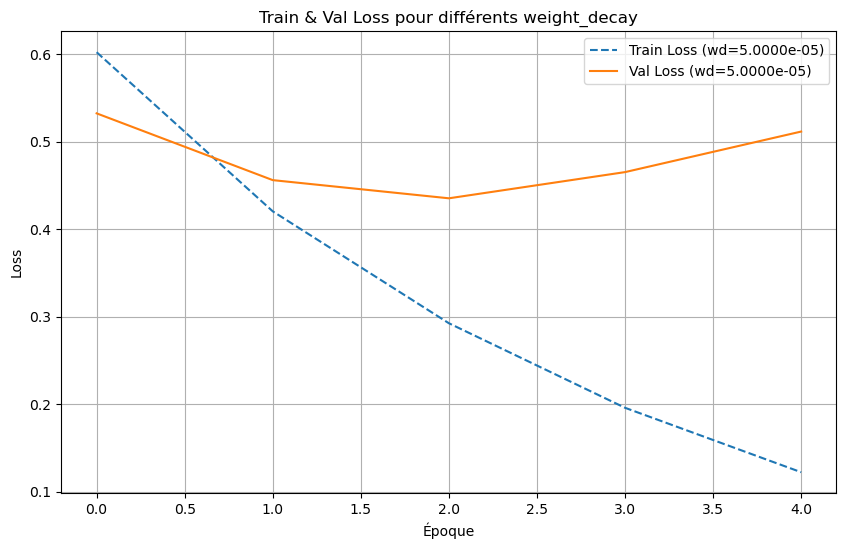

In [11]:
# Définir le chemin du modèle sauvegardé
model_path = "./Camembert/camembert_modele_1"
loss_file = os.path.join(model_path, "losses.json")

# Charger les pertes sauvegardées
with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

#  Vérifier et adapter les clés
train_losses_wd = {float(k): v for k, v in train_losses.items()}
val_losses_wd = {float(k): v for k, v in val_losses.items()}

#  Visualisation des pertes en fonction du `weight_decay`
plt.figure(figsize=(10, 6))
for wd in sorted(train_losses_wd.keys()):  # Trier pour un affichage plus clair
    plt.plot(train_losses_wd[wd], label=f"Train Loss (wd={wd:.4e})", linestyle="--")
    plt.plot(val_losses_wd[wd], label=f"Val Loss (wd={wd:.4e})")

plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()



 Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.69      0.77      0.73       311
Jeu vidéo, accessoire tech.       0.77      0.81      0.79       251
         Accessoire Console       0.82      0.89      0.85       167
             Console de jeu       0.97      0.80      0.87        83
                   Figurine       0.80      0.82      0.81       267
           Carte Collection       0.96      0.93      0.94       396
                Jeu Plateau       0.63      0.63      0.63        76
  Jouet enfant, déguisement       0.79      0.81      0.80       486
             Jeu de société       0.77      0.66      0.71       207
                 Jouet tech       0.97      0.96      0.97       505
       Paire de chaussettes       0.93      0.89      0.91        80
    Jeu extérieur, vêtement       0.90      0.77      0.83       249
             Autour du bébé       0.84      0.85      

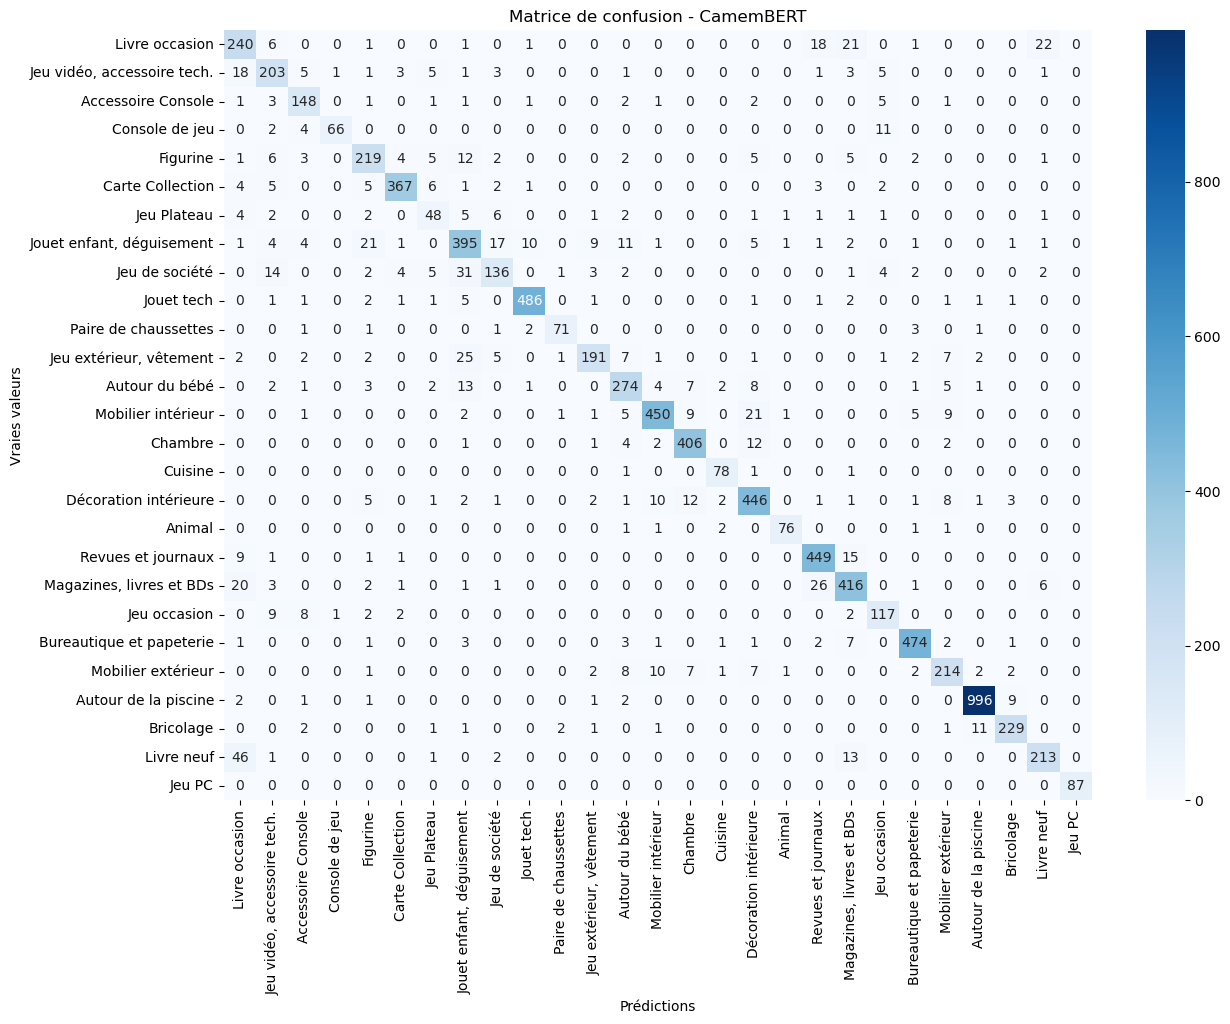

In [13]:
#  Définir le chemin du modèle sauvegardé
model_path = "./Camembert/camembert_modele_1"

#  Recharger le modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

#  Vérifier si le modèle est bien chargé sur GPU si disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

#  Effectuer les prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)
y_pred = predictions.predictions.argmax(axis=1)

#  Charger les vraies étiquettes
y_val_true = np.array(val_dataset["label"])


#  Vérifier si toutes les prédictions existent dans inverse_label_mapping
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette de prédiction ({e}) ne correspond pas à inverse_label_mapping.")
    raise

#  Calcul du F1-score weighted
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

#  Vérifier si labelcat est bien défini et générer les noms des classes
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))

#  Affichage du rapport de classification avec les noms des classes
print("\n Évaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f" F1-score (weighted) : {weighted_f1:.4f}")


#  Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)


#  Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


# **Modele 3 Optimisation du learning rate**

### LR 3e-5

In [9]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 3e-5
weight_decay = 0.001  
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels)

# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_3/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_3/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,  
    warmup_steps=500,
    logging_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_3/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


 Test avec learning rate = 3e-05 et weight_decay = 0.001


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_16396\3609771736.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.803500,0.643847,0.829456,0.824224
2,0.498900,0.481143,0.860517,0.860099
3,0.375400,0.427278,0.877170,0.876909
4,0.277300,0.427456,0.882131,0.881989
5,0.197900,0.442838,0.887091,0.887142



 Résultats pour lr=3e-05 et weight_decay=0.001 | Validation Loss: 0.4273 | F1-score: 0.8769
 Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_3/camembert_lr3e-05_wd1e-03_ep10\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_3/camembert_lr3e-05_wd1e-03_ep10


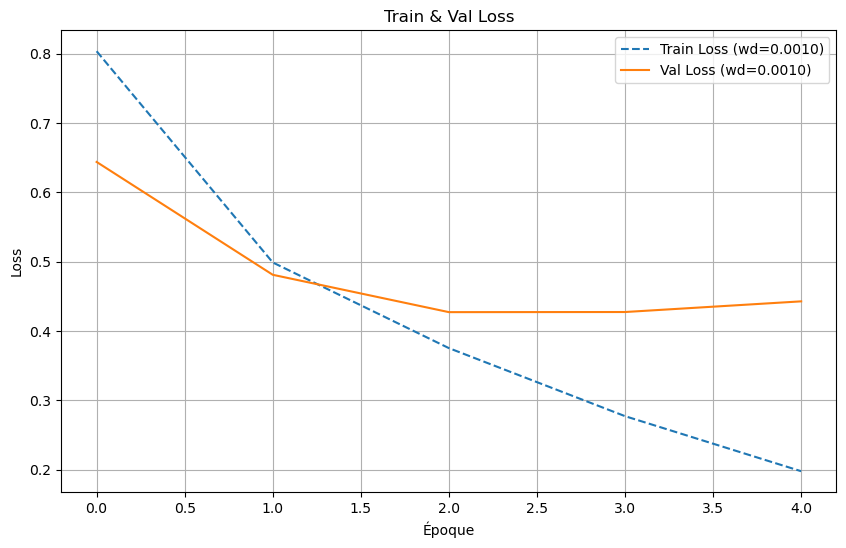

In [16]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_3"
lr = 3e-5
wd = 1e-3
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


Modèle chargé sur : cuda



Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.67      0.70      0.68       311
Jeu vidéo, accessoire tech.       0.72      0.80      0.76       251
         Accessoire Console       0.81      0.88      0.84       167
             Console de jeu       0.98      0.78      0.87        83
                   Figurine       0.78      0.83      0.80       267
           Carte Collection       0.94      0.91      0.92       396
                Jeu Plateau       0.62      0.59      0.61        76
  Jouet enfant, déguisement       0.75      0.83      0.79       486
             Jeu de société       0.77      0.55      0.64       207
                 Jouet tech       0.97      0.96      0.97       505
       Paire de chaussettes       0.91      0.88      0.89        80
    Jeu extérieur, vêtement       0.88      0.80      0.84       249
             Autour du bébé       0.82      0.87      0

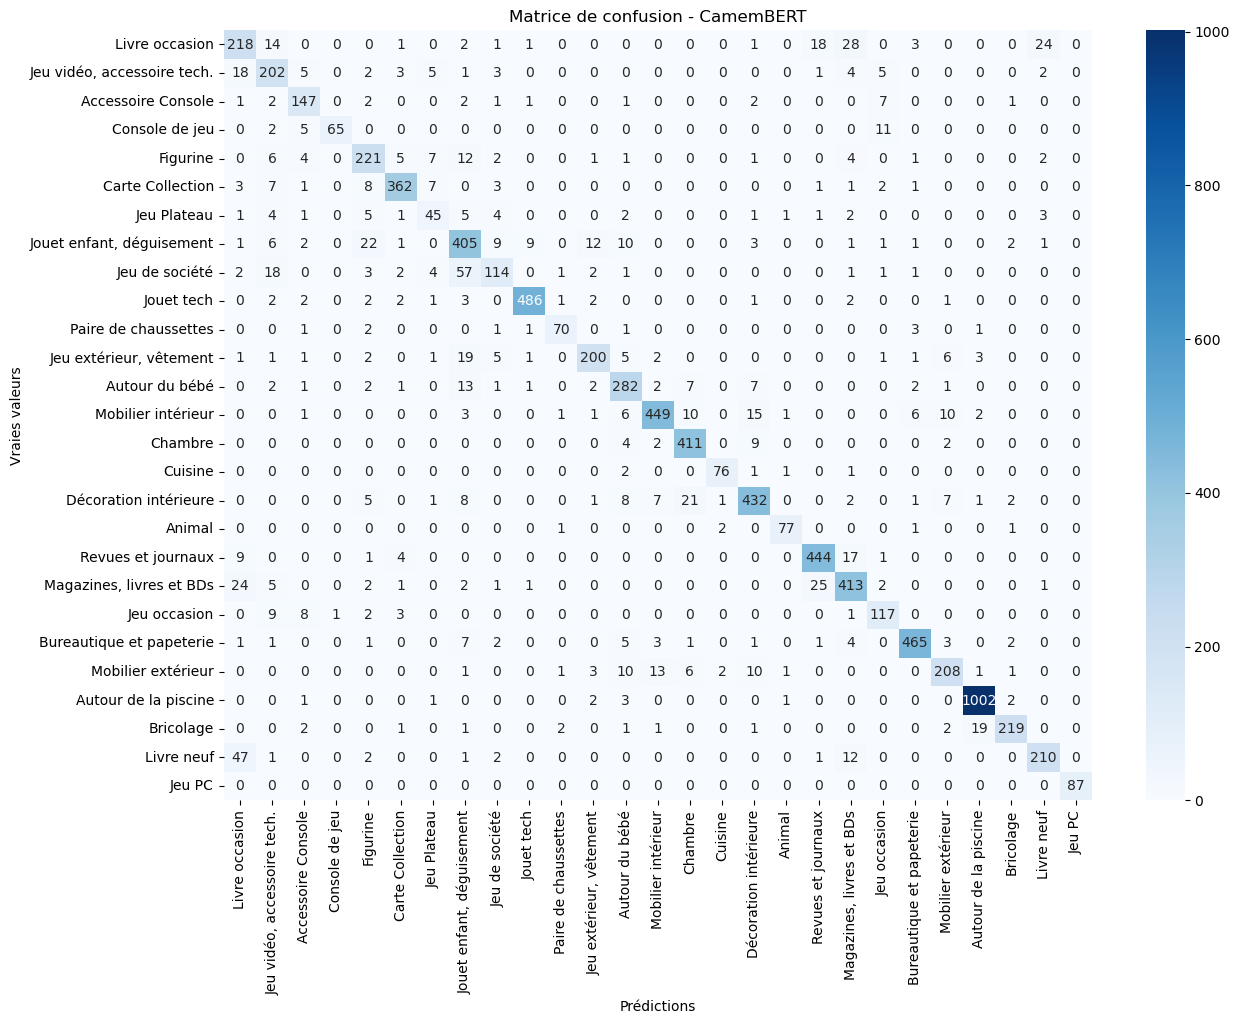

In [17]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_3\camembert_lr3e-05_wd1e-03_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


### LR 2e-5

In [10]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 2e-5
weight_decay = 0.001  
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels)

# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_3/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_3/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,  
    warmup_steps=500,
    logging_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_3/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


 Test avec learning rate = 2e-05 et weight_decay = 0.001


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_41436\3613364319.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.957500,0.765294,0.811858,0.804555
2,0.552600,0.536562,0.849888,0.847595
3,0.428100,0.462910,0.869139,0.868319
4,0.325100,0.451680,0.876698,0.876390
5,0.256900,0.454534,0.881422,0.880860
6,0.194400,0.461320,0.881894,0.881146



 Résultats pour lr=2e-05 et weight_decay=0.001 | Validation Loss: 0.4517 | F1-score: 0.8764
 Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_3/camembert_lr2e-05_wd1e-03_ep10\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_3/camembert_lr2e-05_wd1e-03_ep10


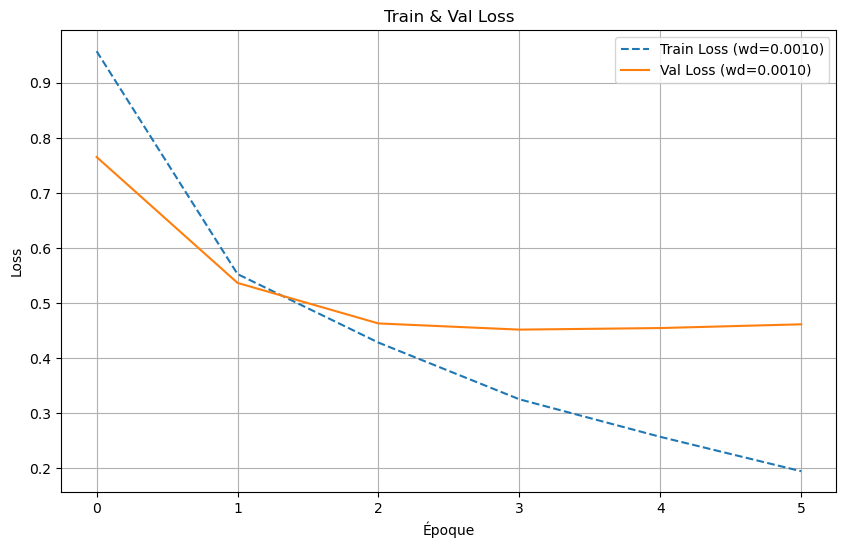

In [11]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_3"
lr = 2e-5
wd = 1e-3
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


Modèle chargé sur : cuda



Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.68      0.77      0.73       311
Jeu vidéo, accessoire tech.       0.73      0.75      0.74       251
         Accessoire Console       0.85      0.85      0.85       167
             Console de jeu       0.87      0.90      0.89        83
                   Figurine       0.80      0.81      0.80       267
           Carte Collection       0.90      0.94      0.92       396
                Jeu Plateau       0.65      0.47      0.55        76
  Jouet enfant, déguisement       0.82      0.79      0.80       486
             Jeu de société       0.77      0.70      0.73       207
                 Jouet tech       0.97      0.96      0.96       505
       Paire de chaussettes       0.88      0.89      0.88        80
    Jeu extérieur, vêtement       0.87      0.78      0.82       249
             Autour du bébé       0.79      0.90      0

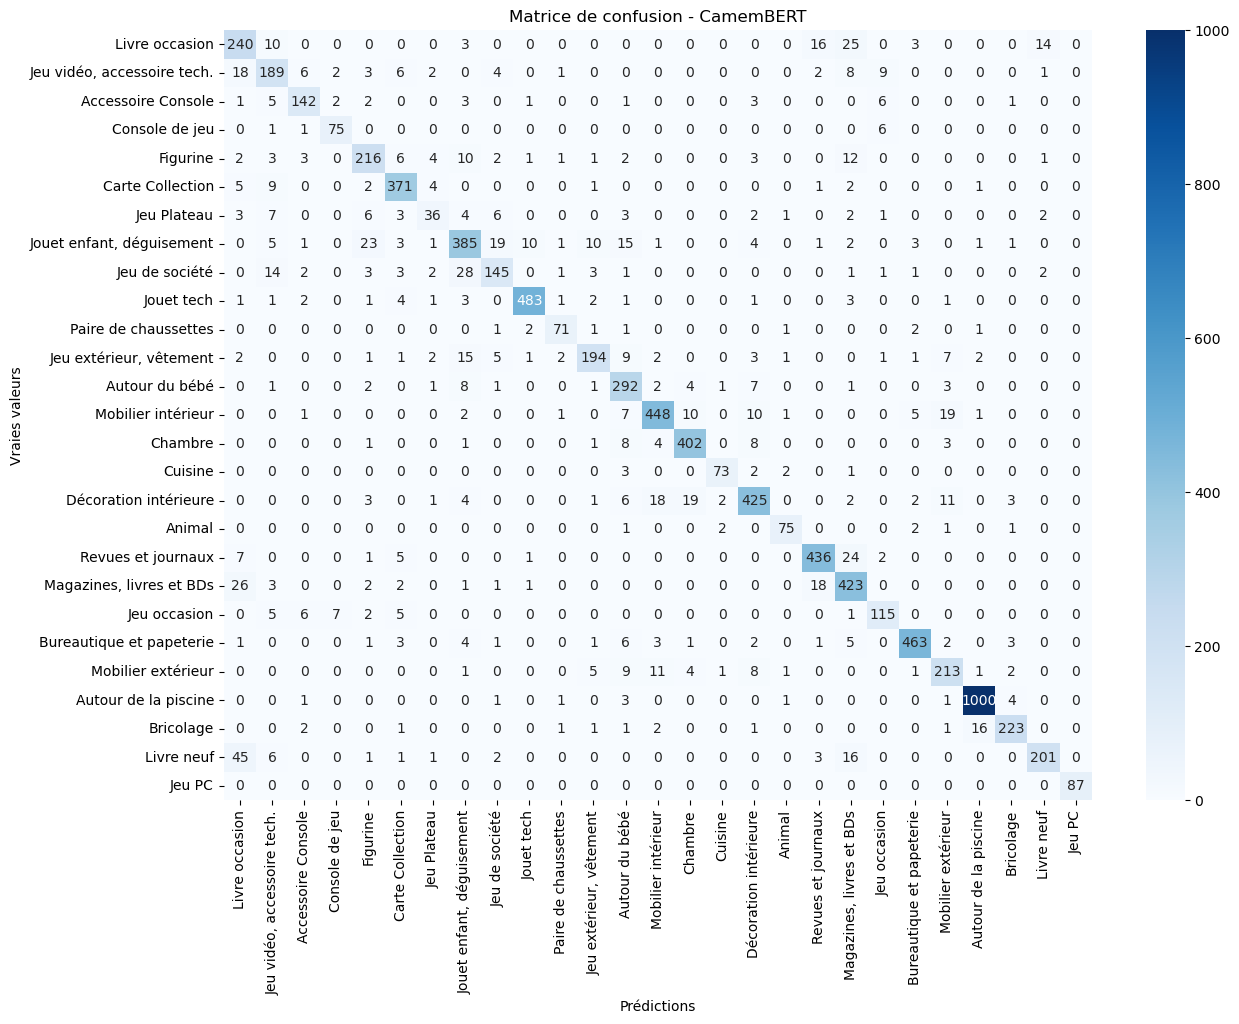

In [12]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_3\camembert_lr2e-05_wd1e-03_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


### LR 5e-5

In [13]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 5e-5
weight_decay = 0.001  
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels)

# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_3/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_3/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,  
    warmup_steps=500,
    logging_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_3/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


 Test avec learning rate = 5e-05 et weight_decay = 0.001


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_41436\3550581776.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.706900,0.581572,0.835597,0.832092
2,0.467900,0.462786,0.865360,0.865284
3,0.359200,0.445192,0.871737,0.870736
4,0.252200,0.439054,0.883312,0.883256
5,0.186000,0.466202,0.887091,0.887358
6,0.123100,0.504487,0.885319,0.885596



 Résultats pour lr=5e-05 et weight_decay=0.001 | Validation Loss: 0.4391 | F1-score: 0.8833
 Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_3/camembert_lr5e-05_wd1e-03_ep10\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_3/camembert_lr5e-05_wd1e-03_ep10


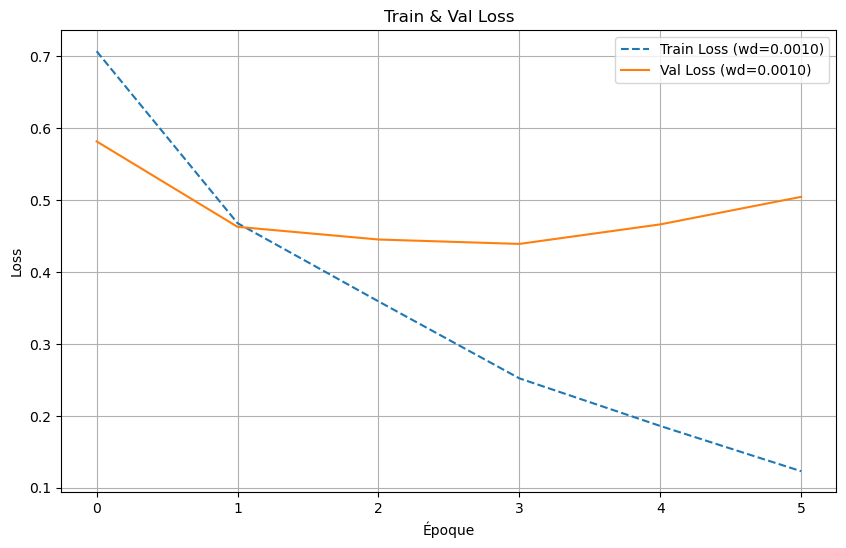

In [14]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_3"
lr = 5e-5
wd = 1e-3
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


Modèle chargé sur : cuda



Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.66      0.78      0.72       311
Jeu vidéo, accessoire tech.       0.74      0.78      0.76       251
         Accessoire Console       0.83      0.87      0.85       167
             Console de jeu       0.87      0.93      0.90        83
                   Figurine       0.75      0.85      0.80       267
           Carte Collection       0.92      0.94      0.93       396
                Jeu Plateau       0.84      0.55      0.67        76
  Jouet enfant, déguisement       0.84      0.75      0.79       486
             Jeu de société       0.73      0.74      0.73       207
                 Jouet tech       0.95      0.97      0.96       505
       Paire de chaussettes       0.94      0.90      0.92        80
    Jeu extérieur, vêtement       0.87      0.82      0.85       249
             Autour du bébé       0.84      0.86      0

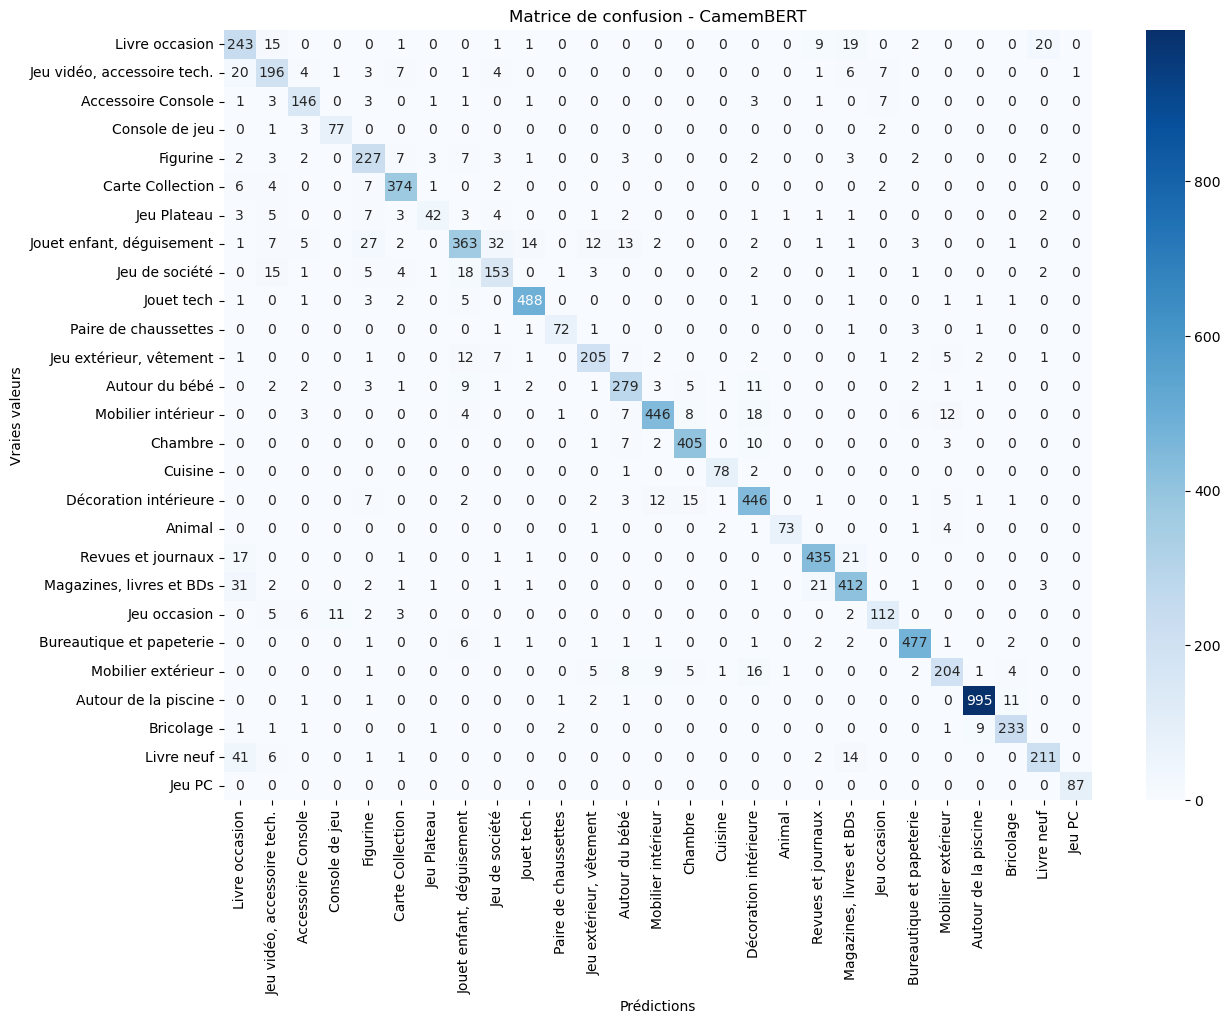

In [15]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_3\camembert_lr5e-05_wd1e-03_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


# **Modele 4 Optimisation du weight decay**

## Weight decay 0.01

In [9]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 5e-5
weight_decay = 0.01  
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels)

# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_4/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_4/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,  
    warmup_steps=500,
    logging_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_4/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


 Test avec learning rate = 5e-05 et weight_decay = 0.01


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_32428\1231705536.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.704900,0.570433,0.836424,0.833186
2,0.462100,0.458783,0.869375,0.869694
3,0.347400,0.436952,0.875517,0.875160
4,0.248900,0.462803,0.878115,0.877784
5,0.176600,0.463126,0.884493,0.884343



 Résultats pour lr=5e-05 et weight_decay=0.01 | Validation Loss: 0.4370 | F1-score: 0.8752
 Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_4/camembert_lr5e-05_wd1e-02_ep10\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_4/camembert_lr5e-05_wd1e-02_ep10


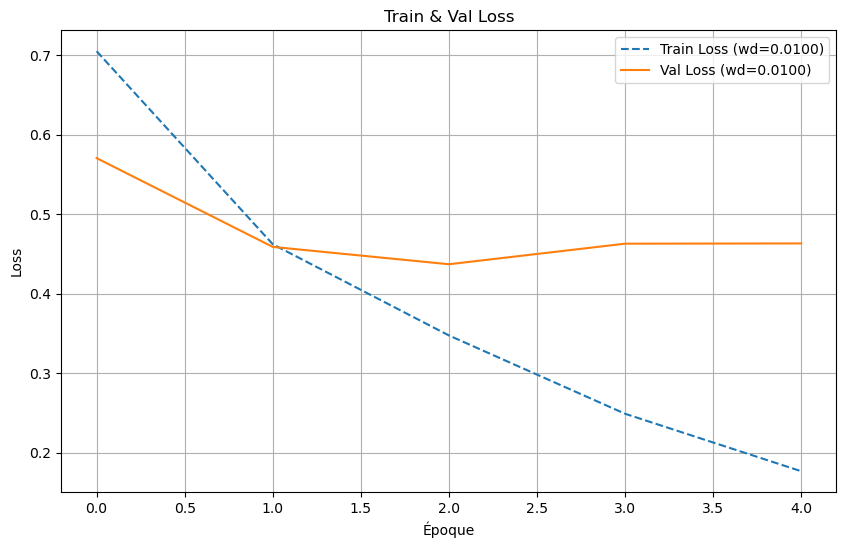

In [10]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_4"
lr = 5e-5
wd = 1e-2
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


Modèle chargé sur : cuda



Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.66      0.74      0.69       311
Jeu vidéo, accessoire tech.       0.81      0.75      0.78       251
         Accessoire Console       0.76      0.90      0.83       167
             Console de jeu       0.95      0.75      0.84        83
                   Figurine       0.76      0.83      0.79       267
           Carte Collection       0.93      0.94      0.94       396
                Jeu Plateau       0.64      0.67      0.65        76
  Jouet enfant, déguisement       0.77      0.81      0.79       486
             Jeu de société       0.80      0.57      0.67       207
                 Jouet tech       0.98      0.95      0.96       505
       Paire de chaussettes       0.90      0.86      0.88        80
    Jeu extérieur, vêtement       0.86      0.79      0.82       249
             Autour du bébé       0.81      0.88      0

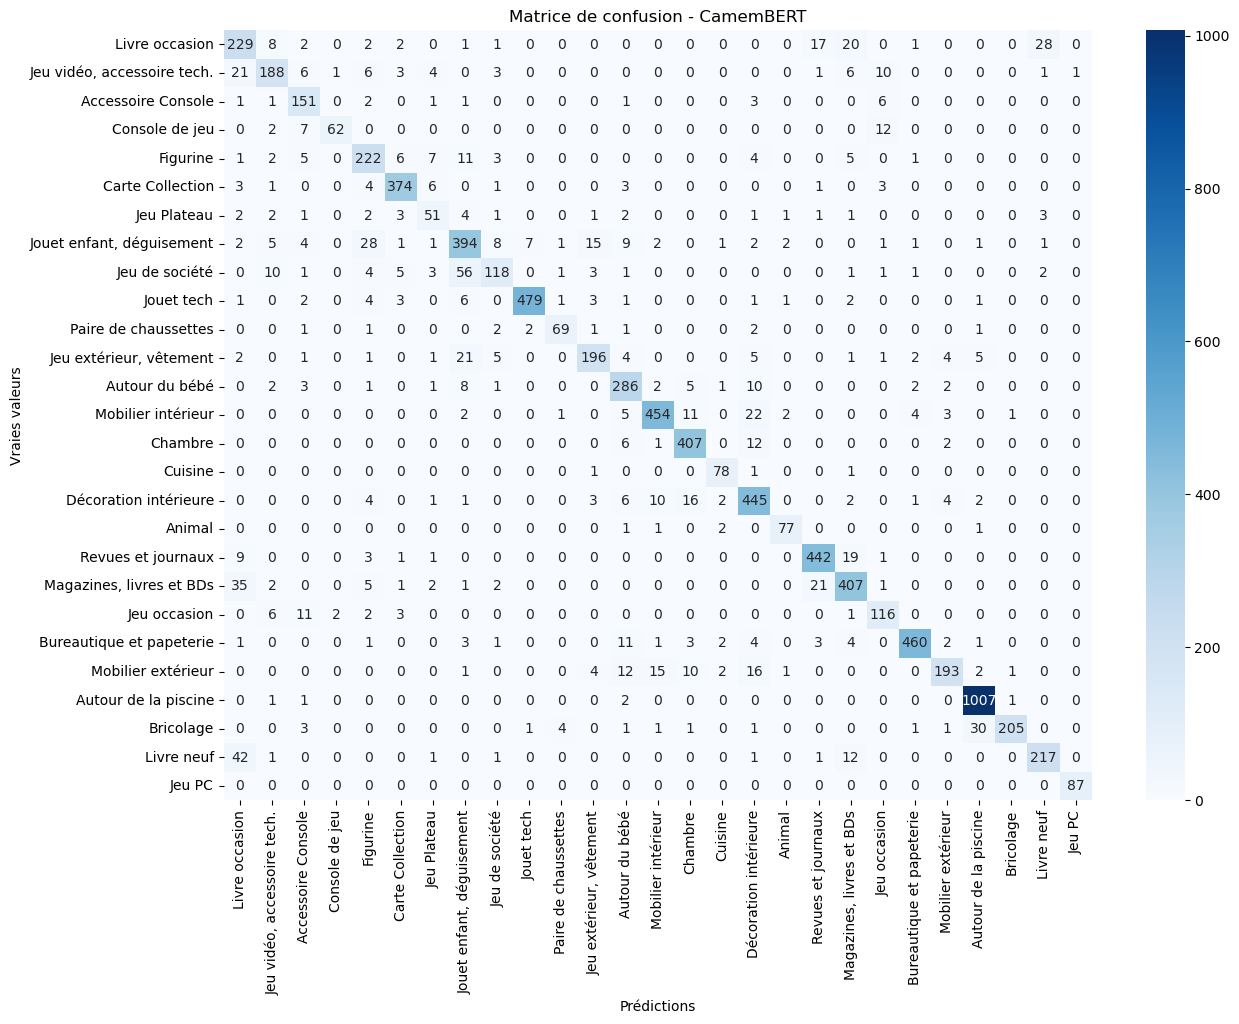

In [11]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_4\camembert_lr5e-05_wd1e-02_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


## Weight decay 0.0001

In [12]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 5e-5
weight_decay = 0.0001
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels)

# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_4/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_4/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,  
    warmup_steps=500,
    logging_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_4/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


 Test avec learning rate = 5e-05 et weight_decay = 0.0001


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_32428\4132396008.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.705500,0.583716,0.833471,0.830008
2,0.471700,0.456911,0.869139,0.869131
3,0.359100,0.441770,0.872564,0.872743
4,0.253000,0.440417,0.883548,0.884178
5,0.179600,0.475438,0.885438,0.885239
6,0.118900,0.502603,0.888863,0.888980



 Résultats pour lr=5e-05 et weight_decay=0.0001 | Validation Loss: 0.4404 | F1-score: 0.8842
 Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_4/camembert_lr5e-05_wd1e-04_ep10\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_4/camembert_lr5e-05_wd1e-04_ep10


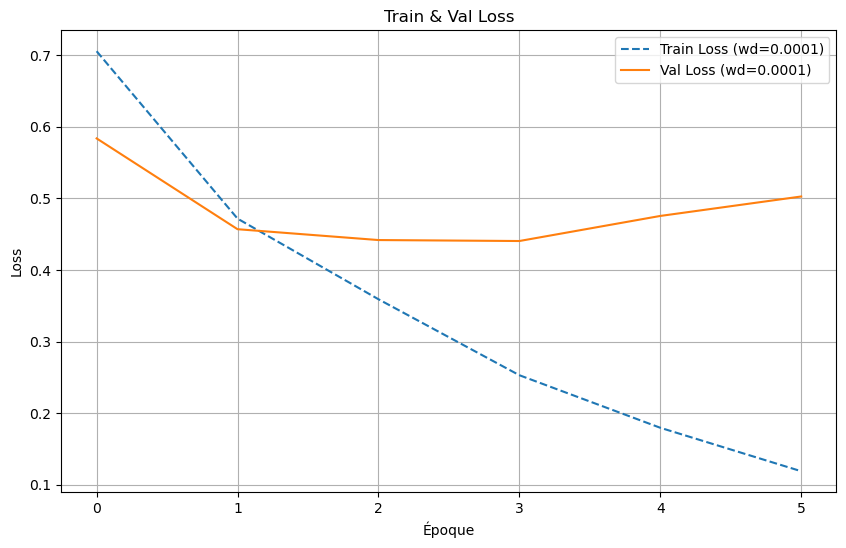

In [13]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_4"
lr = 5e-5
wd = 1e-4
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


Modèle chargé sur : cuda



Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.64      0.74      0.69       311
Jeu vidéo, accessoire tech.       0.74      0.80      0.77       251
         Accessoire Console       0.83      0.84      0.84       167
             Console de jeu       0.89      0.93      0.91        83
                   Figurine       0.77      0.84      0.80       267
           Carte Collection       0.94      0.91      0.93       396
                Jeu Plateau       0.79      0.59      0.68        76
  Jouet enfant, déguisement       0.85      0.78      0.82       486
             Jeu de société       0.74      0.76      0.75       207
                 Jouet tech       0.97      0.97      0.97       505
       Paire de chaussettes       0.96      0.89      0.92        80
    Jeu extérieur, vêtement       0.86      0.82      0.84       249
             Autour du bébé       0.80      0.88      0

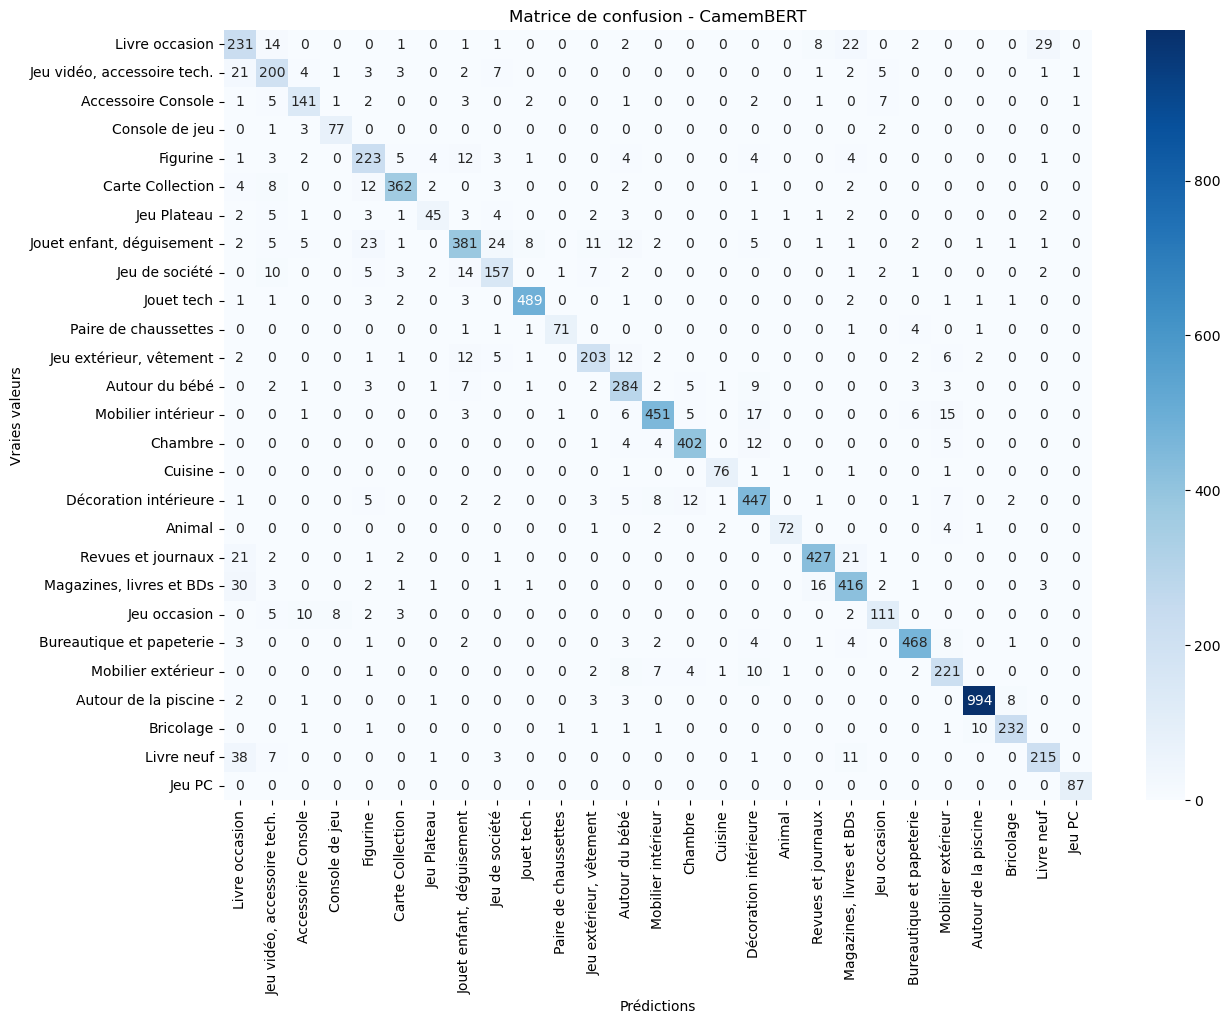

In [14]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_4\camembert_lr5e-05_wd1e-04_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


## Weight decay 0.1

In [9]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 5e-5
weight_decay = 0.1
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels)

# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_4/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_4/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2, 
    warmup_steps=500,
    logging_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_4/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


 Test avec learning rate = 5e-05 et weight_decay = 0.1


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_51852\1499528512.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.704800,0.585511,0.834888,0.832283
2,0.461400,0.471143,0.862171,0.862381
3,0.344600,0.433772,0.875871,0.875072
4,0.249300,0.432775,0.885083,0.884712
5,0.180200,0.464047,0.887563,0.887031
6,0.116200,0.505612,0.887327,0.887059



 Résultats pour lr=5e-05 et weight_decay=0.1 | Validation Loss: 0.4328 | F1-score: 0.8847
 Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_4/camembert_lr5e-05_wd1e-01_ep10\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_4/camembert_lr5e-05_wd1e-01_ep10


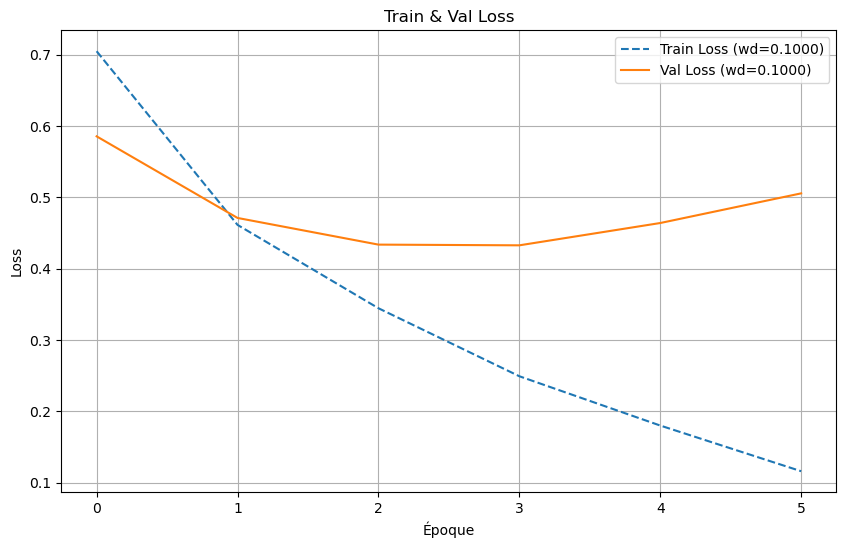

In [10]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_4"
lr = 5e-5
wd = 1e-1
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


Modèle chargé sur : cuda



Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.69      0.73      0.71       311
Jeu vidéo, accessoire tech.       0.75      0.78      0.77       251
         Accessoire Console       0.87      0.87      0.87       167
             Console de jeu       0.85      0.93      0.89        83
                   Figurine       0.77      0.86      0.81       267
           Carte Collection       0.93      0.94      0.94       396
                Jeu Plateau       0.78      0.61      0.68        76
  Jouet enfant, déguisement       0.87      0.76      0.81       486
             Jeu de société       0.76      0.72      0.74       207
                 Jouet tech       0.97      0.97      0.97       505
       Paire de chaussettes       0.94      0.91      0.92        80
    Jeu extérieur, vêtement       0.86      0.83      0.84       249
             Autour du bébé       0.86      0.85      0

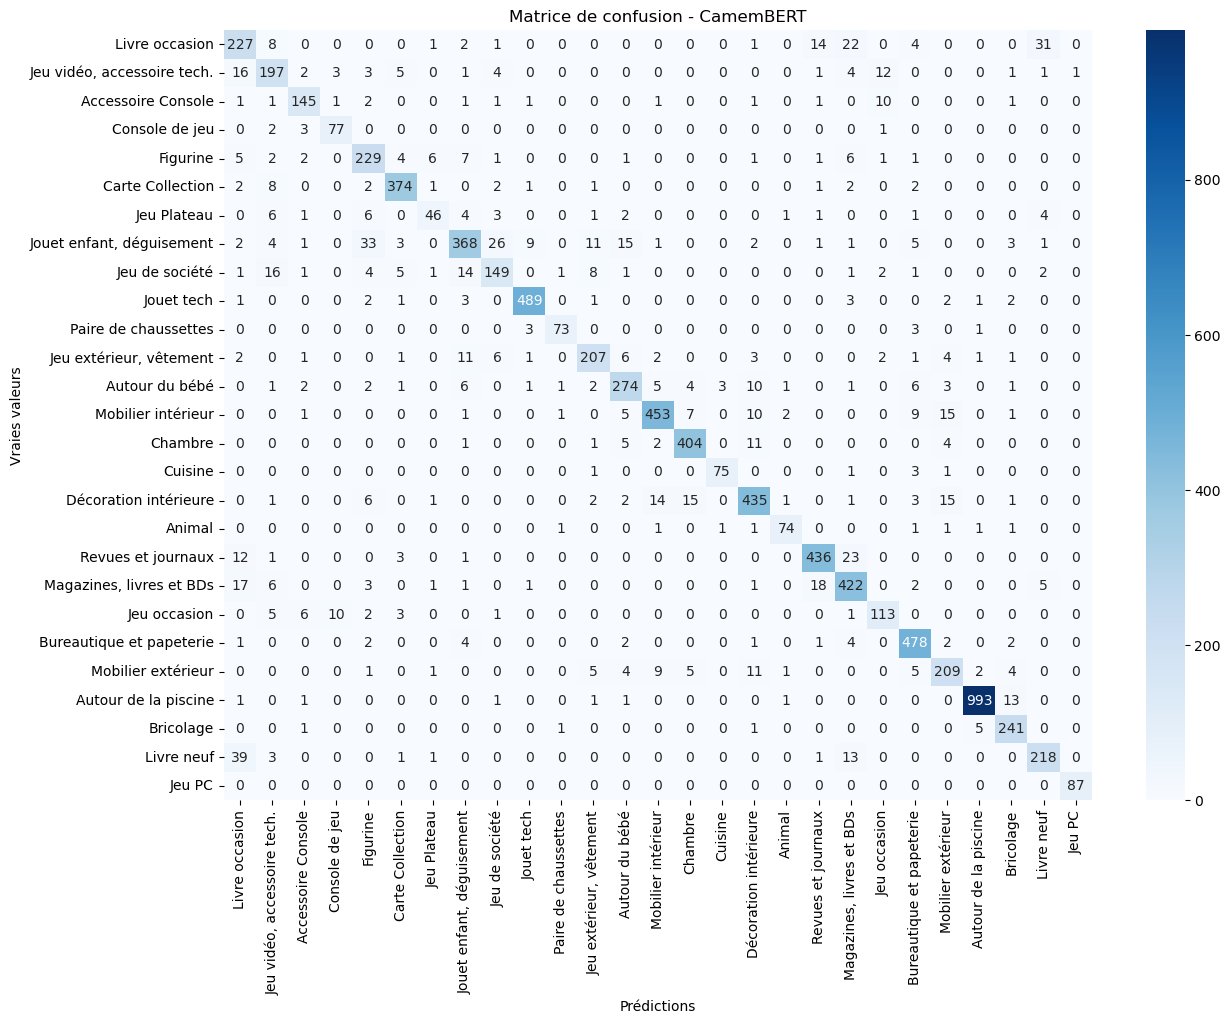

In [11]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_4\camembert_lr5e-05_wd1e-01_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


# **Modele 5: Gridsearch scheduler + gradient accumulation + warmup**

In [ ]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Paramètres fixes
lr = 5e-5
weight_decay = 0.001
num_train_epochs = 5
batch_size = 16

# GridSearch : Liste des valeurs à tester
gradient_accumulation_options = [1, 4]
lr_scheduler_options = ["linear", "cosine_with_restarts"]
warmup_steps_options = [500, 1000]

# Initialisation des dictionnaires pour stocker les pertes et résultats
train_losses = {}
val_losses = {}
gridsearch_results = []

# Boucle sur toutes les combinaisons possibles (8 configs)
for gradient_accumulation_steps, lr_scheduler_type, warmup_steps in product(
    gradient_accumulation_options, lr_scheduler_options, warmup_steps_options
):
    print(f"\n Test config: GA={gradient_accumulation_steps}, Scheduler={lr_scheduler_type}, Warmup={warmup_steps}")

    # Chargement du modele
    num_labels = len(label_mapping)  
    model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels)
    
    # Utilisation du GPU si disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(" Modèle Camembert chargé sur", device)

    # Définition des arguments d'entraînement
    model_folder = f"./Camembert/camembert_modele_5/camembert_lr_{lr:.0e}_wd_{weight_decay:.0e}_ga_{gradient_accumulation_steps}_sched_{lr_scheduler_type}_wu_{warmup_steps}"
    os.makedirs(model_folder, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=model_folder,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        logging_dir=f"./Camembert/camembert_modele_5/logs_camembert_lr_{lr:.0e}_wd_{weight_decay:.0e}_ga_{gradient_accumulation_steps}_sched_{lr_scheduler_type}_wu_{warmup_steps}",
        load_best_model_at_end=True,
        save_total_limit=1,
        fp16=True,
        lr_scheduler_type=lr_scheduler_type,
        gradient_accumulation_steps=gradient_accumulation_steps,
        warmup_steps=warmup_steps,
        logging_steps=500
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Initialisation des listes pour stocker les pertes
    train_losses[lr] = []
    val_losses[lr] = []

    # Entraînement
    trainer.train()

    # Récupération des pertes par époque
    val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
    train_losses[lr] = []
    epoch_losses = []
    for log in trainer.state.log_history:
        if "loss" in log:
            epoch_losses.append(log["loss"])
        if "eval_loss" in log:  # À chaque validation, enregistrer la dernière perte d'entraînement
            if epoch_losses:
                train_losses[lr].append(epoch_losses[-1])  # Sauvegarde la dernière loss de chaque époque
                epoch_losses = []  # Réinitialise la liste pour l'époque suivante

    # Évaluation du modèle sur l’ensemble de validation
    eval_results = trainer.evaluate()
    validation_loss = eval_results["eval_loss"]
    f1_weighted = eval_results["eval_f1_weighted"]

    print(f"\n Résultats pour GA={gradient_accumulation_steps}, Scheduler={lr_scheduler_type}, Warmup={warmup_steps} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

    # Stocker les résultats pour cette configuration
    gridsearch_results.append({
        "gradient_accumulation_steps": gradient_accumulation_steps,
        "lr_scheduler_type": lr_scheduler_type,
        "warmup_steps": warmup_steps,
        "validation_loss": validation_loss,
        "f1_weighted": f1_weighted
    })

    # Sauvegarde du modèle entraîné
    trainer.save_model(model_folder)

    # Sauvegarde du tokenizer
    tokenizer.save_pretrained(model_folder)

    # Sauvegarde des pertes sous format JSON
    losses = {
        "train_losses": {k: list(v) for k, v in train_losses.items()},
        "val_losses": {k: list(v) for k, v in val_losses.items()}
    }

    loss_file = os.path.join(model_folder, "losses.json")

    with open(loss_file, "w") as f:
        json.dump(losses, f)

    print(f"  Train Loss et Val Loss sauvegardés dans : {loss_file}")
    print(f" Modèle et tokenizer sauvegardés dans : {model_folder}")

# Sauvegarde des résultats du GridSearch en JSON
results_path = "./Camembert/camembert_modele_5/camembert_gridsearch_resultss.json"
with open(results_path, "w") as f:
    json.dump(gridsearch_results, f, indent=4)

print(f"\n Tous les résultats sont sauvegardés dans {results_path}")



 Test config: GA=1, Scheduler=linear, Warmup=500


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_22340\3760130912.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.632000,0.543656,0.838432,0.838058
2,0.429400,0.454923,0.870911,0.871595
3,0.304600,0.443265,0.882603,0.882542
4,0.206900,0.473493,0.889099,0.889000
5,0.130200,0.507930,0.886619,0.886735



 Résultats pour GA=1, Scheduler=linear, Warmup=500 | Validation Loss: 0.4433 | F1-score: 0.8825
  Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_5/camembert_lr_5e-05_wd_1e-03_ga_1_sched_linear_wu_500\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_5/camembert_lr_5e-05_wd_1e-03_ga_1_sched_linear_wu_500

 Test config: GA=1, Scheduler=linear, Warmup=1000


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_22340\3760130912.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.643100,0.539385,0.841857,0.841219
2,0.446800,0.457542,0.865360,0.865481
3,0.309900,0.433020,0.882839,0.882409
4,0.222800,0.464519,0.888154,0.888079


In [ ]:
# Fonction pour extraire GA, Scheduler et Warmup Steps correctement
def extract_config(folder_name):
    match = re.search(r"ga_(\d+)_sched_([\w_]+)_wu_(\d+)", folder_name)
    if match:
        ga = match.group(1)  # Nombre de gradient accumulation steps
        scheduler = match.group(2)  # Type de scheduler
        warmup = match.group(3)  # Nombre de warmup steps
        return (ga, scheduler, warmup)
    return None

#Extraction
for folder in os.listdir("./Camembert/camembert_modele_5"):
    extracted = extract_config(folder)
    if extracted:
        print(f"Extraction réussie : {extracted}")
    else:
        print(f"Problème d'extraction avec : {folder}")


In [ ]:
#Graphique Train et Val Loss
if not train_losses or not val_losses:
    print("Pas de pertes chargées depuis les fichiers, vérifiez les sauvegardes.")
else:
    num_configs = len(train_losses)  # Nombre total de configurations testées
    fig, axes = plt.subplots(num_configs, 1, figsize=(8, 4 * num_configs), sharex=True) 

    if num_configs == 1:
        axes = [axes]

    for ax, (config, train_loss_values) in zip(axes, train_losses.items()):
        if config in val_losses:
            val_loss_values = val_losses[config]
            label = f"GA={config[0]}, Scheduler={config[1]}, WU={config[2]}"

            ax.plot(train_loss_values, label="Train Loss", linestyle="--")
            ax.plot(val_loss_values, label="Val Loss")
            ax.set_ylabel("Loss")
            ax.set_title(f"Config {label}")
            ax.legend()
            ax.grid()

    plt.xlabel("Époque")
    plt.tight_layout()
    plt.show()


In [ ]:
# Tri des configurations par F1-score
sorted_configs = sorted(results, key=lambda x: x["f1_weighted"], reverse=True)

# Création des subplots pour afficher toutes les matrices de confusion
fig, axes = plt.subplots(len(sorted_configs), 1, figsize=(12, 6 * len(sorted_configs))) 

"""
if len(sorted_configs) == 1:
    axes = [axes]  # S'assurer que axes est toujours une liste
"""

for ax, config in zip(axes, sorted_configs):
    # Chemin du modèle entraîné
    model_path = f"./Camembert/camembert_modele_5/camembert_lr_2e-05_wd_1e-03_ga_{config['gradient_accumulation_steps']}_sched_{config['lr_scheduler_type']}_wu_{config['warmup_steps']}"

    # Chargement modèle et tokenizer
    model = CamembertForSequenceClassification.from_pretrained(model_path)
    model.to(device)

    # Prédictions
    trainer = best_trainer  # Assurez-vous que best_trainer est défini
    predictions = trainer.predict(val_dataset)
    y_pred = predictions.predictions.argmax(axis=1)

    # Matrice de confusion
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels, ax=ax)
    ax.set_xticklabels(category_labels, rotation=90, ha="center", fontsize=10) 
    ax.set_yticklabels(category_labels, rotation=0, ha="right", fontsize=10)  
    ax.set_title(f"GA={config['gradient_accumulation_steps']}, {config['lr_scheduler_type']}, WU={config['warmup_steps']} | F1-score: {config['f1_weighted']:.4f}")
    ax.set_xlabel("Prédictions")
    ax.set_ylabel("Vraies valeurs")

plt.tight_layout()
plt.show()


# **Modele 6: Dropout 0.3**

## Choix LR

### LR 5.10-5

In [15]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 5e-5
weight_decay = 0.001  
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", attention_probs_dropout_prob=0.3,  # Augmente le dropout
        hidden_dropout_prob=0.3, num_labels=num_labels)


# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_6/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_6/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,  
    warmup_steps=500,
    logging_steps=500
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_6/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


 Test avec learning rate = 5e-05 et weight_decay = 0.001


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_34536\1043159664.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,1.062100,0.842291,0.762135,0.751100
2,0.745700,0.668246,0.804417,0.798887
3,0.657700,0.581988,0.829928,0.827385
4,0.542300,0.529826,0.849652,0.849105
5,0.480600,0.500563,0.861226,0.860910
6,0.403700,0.487709,0.861108,0.860373
7,0.380600,0.470905,0.867604,0.867238
8,0.339600,0.462641,0.870438,0.870327
9,0.324100,0.458590,0.872210,0.871706
10,0.311500,0.460365,0.871383,0.871006



 Résultats pour lr=5e-05 et weight_decay=0.001 | Validation Loss: 0.4586 | F1-score: 0.8717
 Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_6/camembert_lr5e-05_wd1e-03_ep10\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_6/camembert_lr5e-05_wd1e-03_ep10


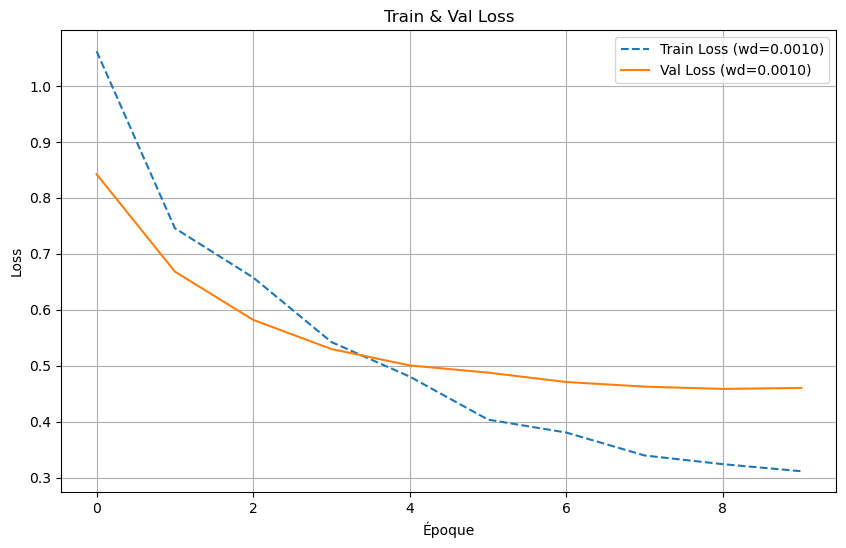

In [16]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_6"
lr = 5e-5
wd = 1e-3
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


Modèle chargé sur : cuda



Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.73      0.67      0.70       311
Jeu vidéo, accessoire tech.       0.70      0.78      0.74       251
         Accessoire Console       0.80      0.89      0.84       167
             Console de jeu       0.90      0.92      0.91        83
                   Figurine       0.80      0.82      0.81       267
           Carte Collection       0.93      0.92      0.92       396
                Jeu Plateau       0.69      0.61      0.64        76
  Jouet enfant, déguisement       0.81      0.75      0.78       486
             Jeu de société       0.71      0.67      0.69       207
                 Jouet tech       0.95      0.96      0.95       505
       Paire de chaussettes       0.90      0.89      0.89        80
    Jeu extérieur, vêtement       0.81      0.79      0.80       249
             Autour du bébé       0.83      0.83      0

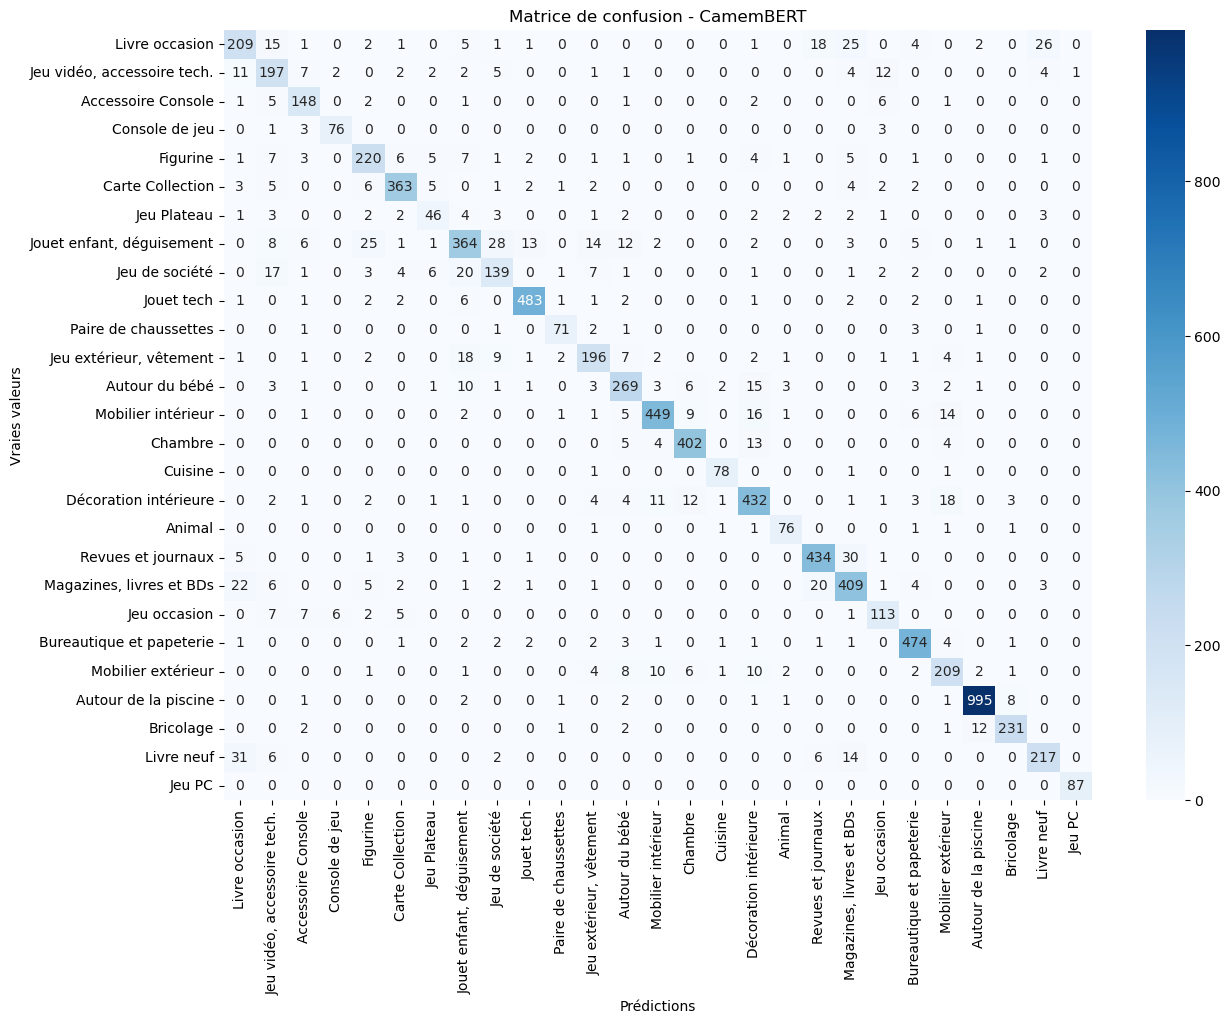

In [17]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_6\camembert_lr5e-05_wd1e-03_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


### LR 2.10-5

In [8]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 2e-5
weight_decay = 0.001  
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", attention_probs_dropout_prob=0.3,  # Augmente le dropout
        hidden_dropout_prob=0.3, num_labels=num_labels)


# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_6/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_6/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,  
    warmup_steps=500,
    logging_steps=500
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_6/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


 Test avec learning rate = 2e-05 et weight_decay = 0.001


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_42400\3623366573.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,1.466500,1.163343,0.687020,0.661252
2,0.918800,0.791670,0.773355,0.765677
3,0.758500,0.666912,0.806779,0.802853
4,0.637800,0.603374,0.826267,0.822573
5,0.574700,0.552036,0.838904,0.837201
6,0.515300,0.552656,0.839849,0.838394
7,0.498300,0.525518,0.847408,0.846257
8,0.465900,0.519349,0.851659,0.850992
9,0.451500,0.512864,0.852250,0.851611
10,0.446100,0.511300,0.852486,0.851859



 Résultats pour lr=2e-05 et weight_decay=0.001 | Validation Loss: 0.5113 | F1-score: 0.8519
 Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_6/camembert_lr2e-05_wd1e-03_ep10\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_6/camembert_lr2e-05_wd1e-03_ep10


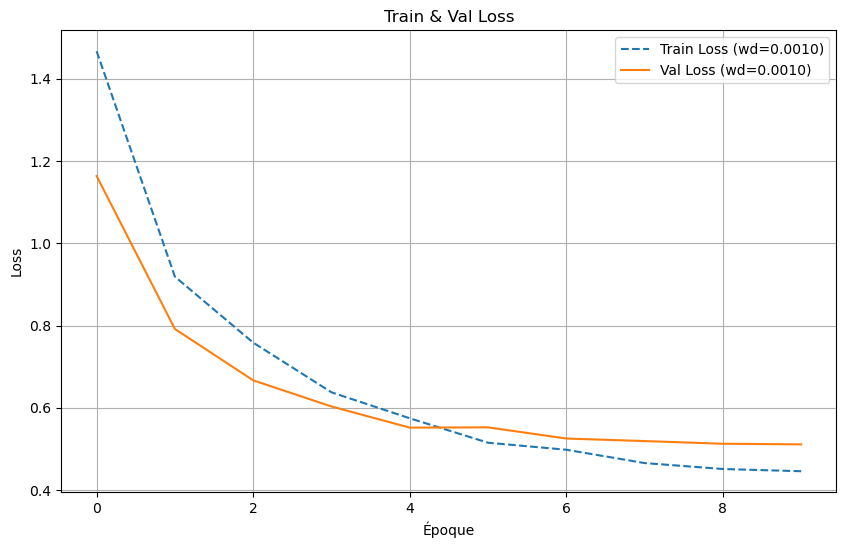

In [9]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_6"
lr = 2e-5
wd = 1e-3
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


Modèle chargé sur : cuda



Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.65      0.68      0.67       311
Jeu vidéo, accessoire tech.       0.68      0.70      0.69       251
         Accessoire Console       0.71      0.82      0.76       167
             Console de jeu       0.89      0.87      0.88        83
                   Figurine       0.73      0.80      0.77       267
           Carte Collection       0.88      0.91      0.89       396
                Jeu Plateau       0.61      0.49      0.54        76
  Jouet enfant, déguisement       0.79      0.77      0.78       486
             Jeu de société       0.75      0.58      0.65       207
                 Jouet tech       0.94      0.95      0.95       505
       Paire de chaussettes       0.89      0.84      0.86        80
    Jeu extérieur, vêtement       0.80      0.77      0.78       249
             Autour du bébé       0.82      0.82      0

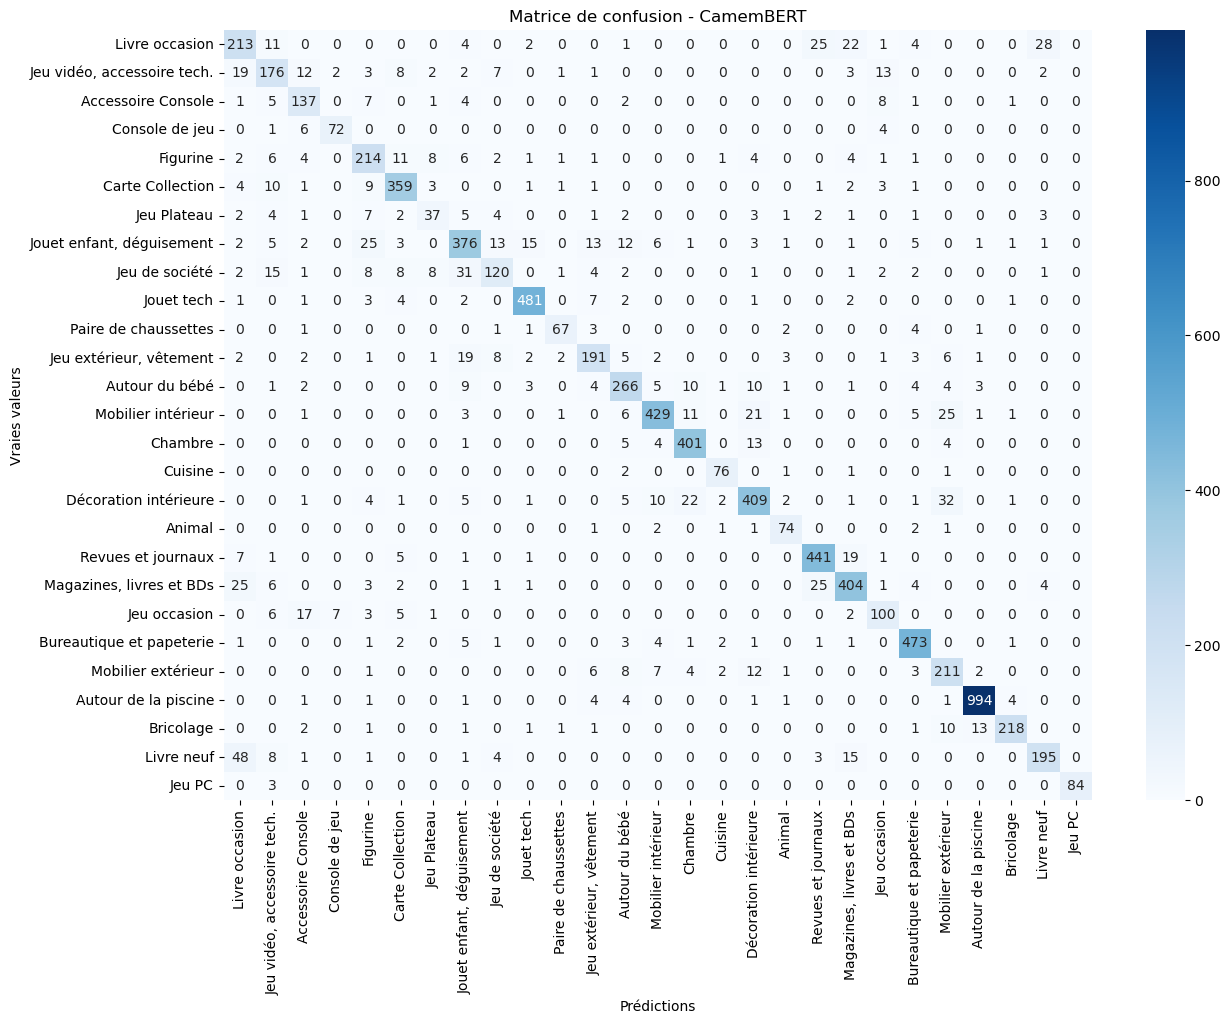

In [10]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_6\camembert_lr2e-05_wd1e-03_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


### LR 3.10-5

In [8]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 3e-5
weight_decay = 0.001  
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", attention_probs_dropout_prob=0.3,  # Augmente le dropout
        hidden_dropout_prob=0.3, num_labels=num_labels)


# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_6/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_6/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,
    warmup_steps=500,
    logging_steps=500
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_6/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


 Test avec learning rate = 3e-05 et weight_decay = 0.001


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_16228\225219094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,1.222500,0.943782,0.742176,0.727159
2,0.794500,0.681501,0.802646,0.796767
3,0.677800,0.581182,0.828629,0.825666
4,0.565800,0.545542,0.843628,0.842047
5,0.508000,0.501015,0.854966,0.854203
6,0.445700,0.499208,0.858864,0.857580
7,0.426900,0.486690,0.863588,0.862834
8,0.389400,0.475737,0.866777,0.866341
9,0.378000,0.473093,0.868667,0.867819
10,0.364900,0.470652,0.868785,0.867959



 Résultats pour lr=3e-05 et weight_decay=0.001 | Validation Loss: 0.4707 | F1-score: 0.8680
 Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_6/camembert_lr3e-05_wd1e-03_ep10\losses.json
 Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_6/camembert_lr3e-05_wd1e-03_ep10


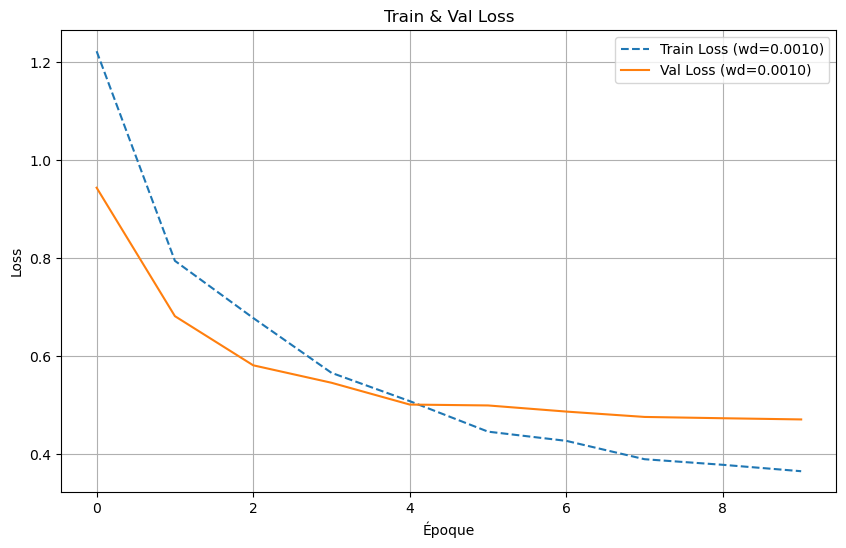

In [9]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_6"
lr = 3e-5
wd = 1e-3
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


Modèle chargé sur : cuda



Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.74      0.66      0.70       311
Jeu vidéo, accessoire tech.       0.69      0.74      0.72       251
         Accessoire Console       0.74      0.89      0.81       167
             Console de jeu       0.91      0.93      0.92        83
                   Figurine       0.77      0.82      0.79       267
           Carte Collection       0.91      0.92      0.92       396
                Jeu Plateau       0.67      0.54      0.60        76
  Jouet enfant, déguisement       0.85      0.75      0.80       486
             Jeu de société       0.73      0.65      0.69       207
                 Jouet tech       0.95      0.95      0.95       505
       Paire de chaussettes       0.91      0.85      0.88        80
    Jeu extérieur, vêtement       0.81      0.80      0.81       249
             Autour du bébé       0.84      0.86      0

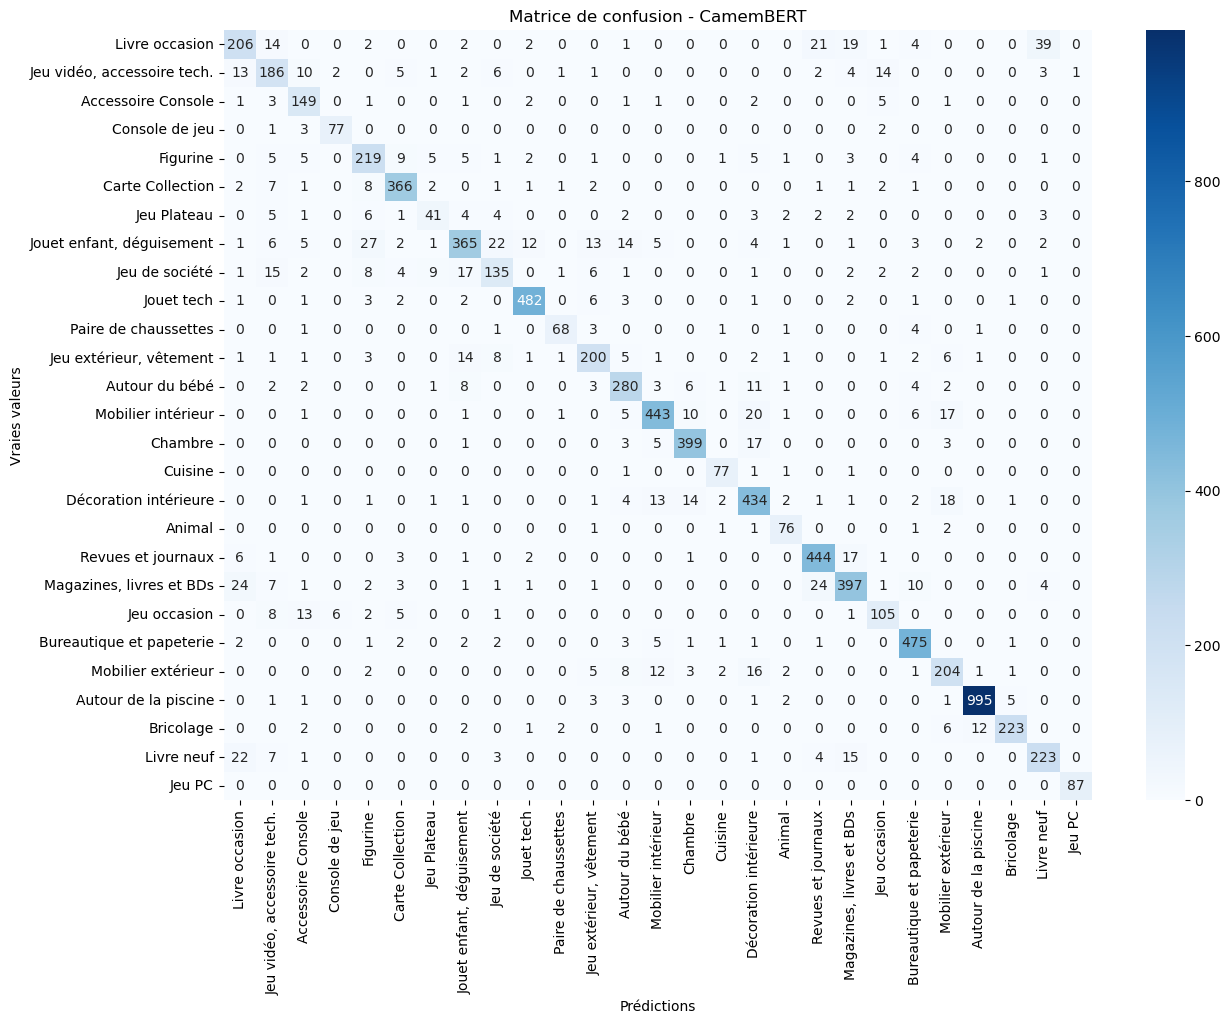

In [10]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_6\camembert_lr3e-05_wd1e-03_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


## Choix WD

### WD 0.01

In [ ]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 5e-5
weight_decay = 0.01  
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", attention_probs_dropout_prob=0.3,  # Augmente le dropout
        hidden_dropout_prob=0.3, num_labels=num_labels)


# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_6/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_6/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,  
    warmup_steps=500,
    logging_steps=500
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_6/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


In [ ]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_6"
lr = 5e-5
wd = 1e-2
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


In [ ]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_6\camembert_lr5e-05_wd1e-02_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


### WD 0.0001

In [ ]:
# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Définition du learning rate et du weight decay unique à tester
lr = 5e-5
weight_decay = 0.0001  
num_train_epochs=10
print(f" Test avec learning rate = {lr} et weight_decay = {weight_decay}")

# Chargement du modele
num_labels = len(label_mapping) 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", attention_probs_dropout_prob=0.3,  # Augmente le dropout
        hidden_dropout_prob=0.3, num_labels=num_labels)


# Utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(" Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_6/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,  
    logging_dir=f"./Camembert/camembert_modele_6/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,  
    warmup_steps=500,
    logging_steps=500
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


# Initialisation des listes pour stocker les pertes
train_losses[lr] = []
val_losses[lr] = []

# Entrainement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:  # À chaque validation, on enregistre la dernière perte d'entraînement
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])  #  Sauvegarde la dernière loss de chaque époque
            epoch_losses = []  # Réinitialise la liste pour l'époque suivante

# Récuperation des pertes d'entraînement et de validation
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats pour lr={lr} et weight_decay={weight_decay} | Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

# Meilleure configuration 
best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_6/camembert_lr{best_training_args.learning_rate:.0e}_wd{best_training_args.weight_decay:.0e}_ep{best_training_args.num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)

# Sauvegarde du tokenizer
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes sous format JSON
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}

loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f" Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f" Modèle et tokenizer sauvegardés dans : {model_path}")


In [ ]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_6"
lr = 5e-5
wd = 1e-4
ep = 10

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


In [ ]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_6\camembert_lr5e-05_wd1e-04_ep10"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


# **Modele 7 : Desequilibre de classes**

## Ponderation interne

In [31]:
# Calcul des poids de classe
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
labels = X_train["label"].values
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Poids de classe calculés :", class_weights_tensor)

# Définition de la fonction de perte pondérée
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Fonction de calcul des métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# Définition d'un Trainer personnalisé avec une fonction de perte personnalisée
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

lr = 5e-5
weight_decay = 0.001 
num_train_epochs = 5

# Initialisation des dictionnaires pour stocker les pertes
train_losses = {}
val_losses = {}

# Chargement du modèle
num_labels = len(label_mapping)
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels)
model.to(device)
print("Modèle Camembert chargé sur", device)

training_args = TrainingArguments(
    output_dir=f"./Camembert/camembert_modele_7/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_train_epochs,
    learning_rate=lr,
    weight_decay=weight_decay,
    logging_dir=f"./Camembert/camembert_modele_7/logs_camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True
)

# Utilisation de CustomTrainer avec fonction de perte pondérée
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_losses[lr] = []
val_losses[lr] = []

# Entraînement
trainer.train()

# Récupération des pertes par époque
val_losses[lr] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
train_losses[lr] = []
epoch_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        epoch_losses.append(log["loss"])
    if "eval_loss" in log:
        if epoch_losses:
            train_losses[lr].append(epoch_losses[-1])
            epoch_losses = []

# Évaluation finale
eval_results = trainer.evaluate()
validation_loss = eval_results["eval_loss"]
f1_weighted = eval_results["eval_f1_weighted"]

print(f"\n Résultats : Validation Loss: {validation_loss:.4f} | F1-score: {f1_weighted:.4f}")

# Stockage des résultats
results = [(lr, weight_decay, validation_loss, f1_weighted, trainer, training_args)]

best_trainer = trainer
best_training_args = training_args

# Sauvegarde du modèle entraîné
model_path = f"./Camembert/camembert_modele_7/camembert_lr{lr:.0e}_wd{weight_decay:.0e}_ep{num_train_epochs}"
os.makedirs(model_path, exist_ok=True)
best_trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

# Sauvegarde des pertes
losses = {
    "train_losses": {k: list(v) for k, v in train_losses.items()},
    "val_losses": {k: list(v) for k, v in val_losses.items()}
}
loss_file = os.path.join(model_path, "losses.json")
with open(loss_file, "w") as f:
    json.dump(losses, f)

print(f"Train Loss et Val Loss sauvegardés dans : {loss_file}")
print(f"Modèle et tokenizer sauvegardés dans : {model_path}")


Poids de classe calculés : tensor([0.9952, 1.2464, 1.8823, 3.7905, 1.1600, 0.7842, 4.0573, 0.6378, 1.5153,
        0.6182, 4.3568, 1.2965, 0.9612, 0.6176, 0.7537, 3.8674, 0.6353, 3.7675,
        0.6510, 0.6503, 2.2016, 0.6252, 1.2358, 0.3146, 1.2558, 1.1232, 3.5516],
       device='cuda:0')


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle Camembert chargé sur cuda


C:\Users\rudy_\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rudy_\AppData\Local\Temp\ipykernel_35660\2048687347.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.679600,0.590962,0.839258,0.840967
2,0.479100,0.489008,0.867013,0.867851
3,0.351200,0.492418,0.885201,0.885372
4,0.221300,0.551755,0.885438,0.885572
5,0.145900,0.570499,0.887800,0.888113



 Résultats : Validation Loss: 0.4890 | F1-score: 0.8679
Train Loss et Val Loss sauvegardés dans : ./Camembert/camembert_modele_7/camembert_lr5e-05_wd1e-03_ep5\losses.json
Modèle et tokenizer sauvegardés dans : ./Camembert/camembert_modele_7/camembert_lr5e-05_wd1e-03_ep5


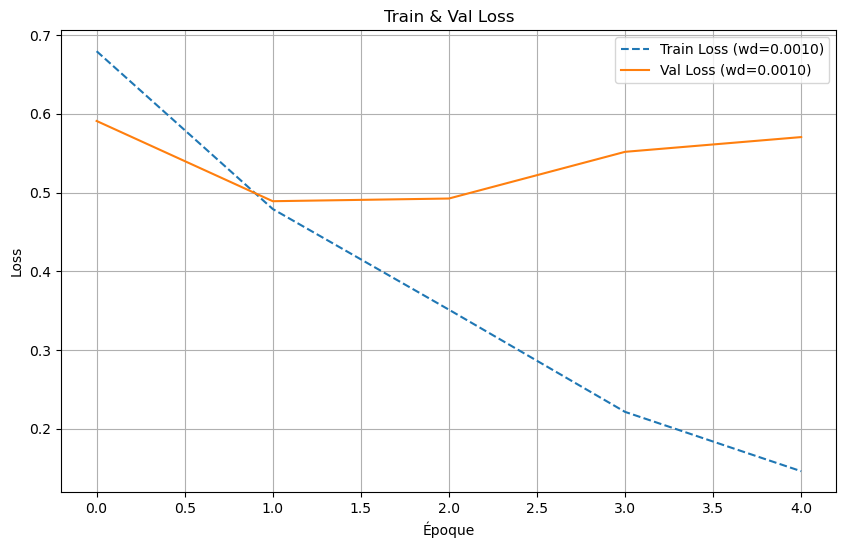

In [32]:
base_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_7"
lr = 5e-5
wd = 1e-3
ep = 5

model_path = os.path.join(base_path, f"camembert_lr{lr:.0e}_wd{wd:.0e}_ep{ep}")
loss_file = os.path.join(model_path, "losses.json")

with open(loss_file, "r") as f:
    losses = json.load(f)

train_losses = losses["train_losses"]
val_losses = losses["val_losses"]

lr_key = list(train_losses.keys())[0]

plt.figure(figsize=(10, 6))
plt.plot(train_losses[lr_key], label=f"Train Loss (wd={wd:.4f})", linestyle="--")
plt.plot(val_losses[lr_key], label=f"Val Loss (wd={wd:.4f})")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Train & Val Loss")
plt.legend()
plt.grid()
plt.show()


Modèle chargé sur : cuda



Évaluation sur le jeu de validation (X_val) :
                             precision    recall  f1-score   support

             Livre occasion       0.67      0.77      0.72       311
Jeu vidéo, accessoire tech.       0.68      0.77      0.72       251
         Accessoire Console       0.82      0.88      0.85       167
             Console de jeu       0.76      0.98      0.86        83
                   Figurine       0.68      0.87      0.76       267
           Carte Collection       0.96      0.89      0.92       396
                Jeu Plateau       0.71      0.64      0.68        76
  Jouet enfant, déguisement       0.85      0.72      0.78       486
             Jeu de société       0.72      0.71      0.72       207
                 Jouet tech       0.96      0.95      0.96       505
       Paire de chaussettes       0.93      0.89      0.91        80
    Jeu extérieur, vêtement       0.80      0.79      0.80       249
             Autour du bébé       0.78      0.84      0

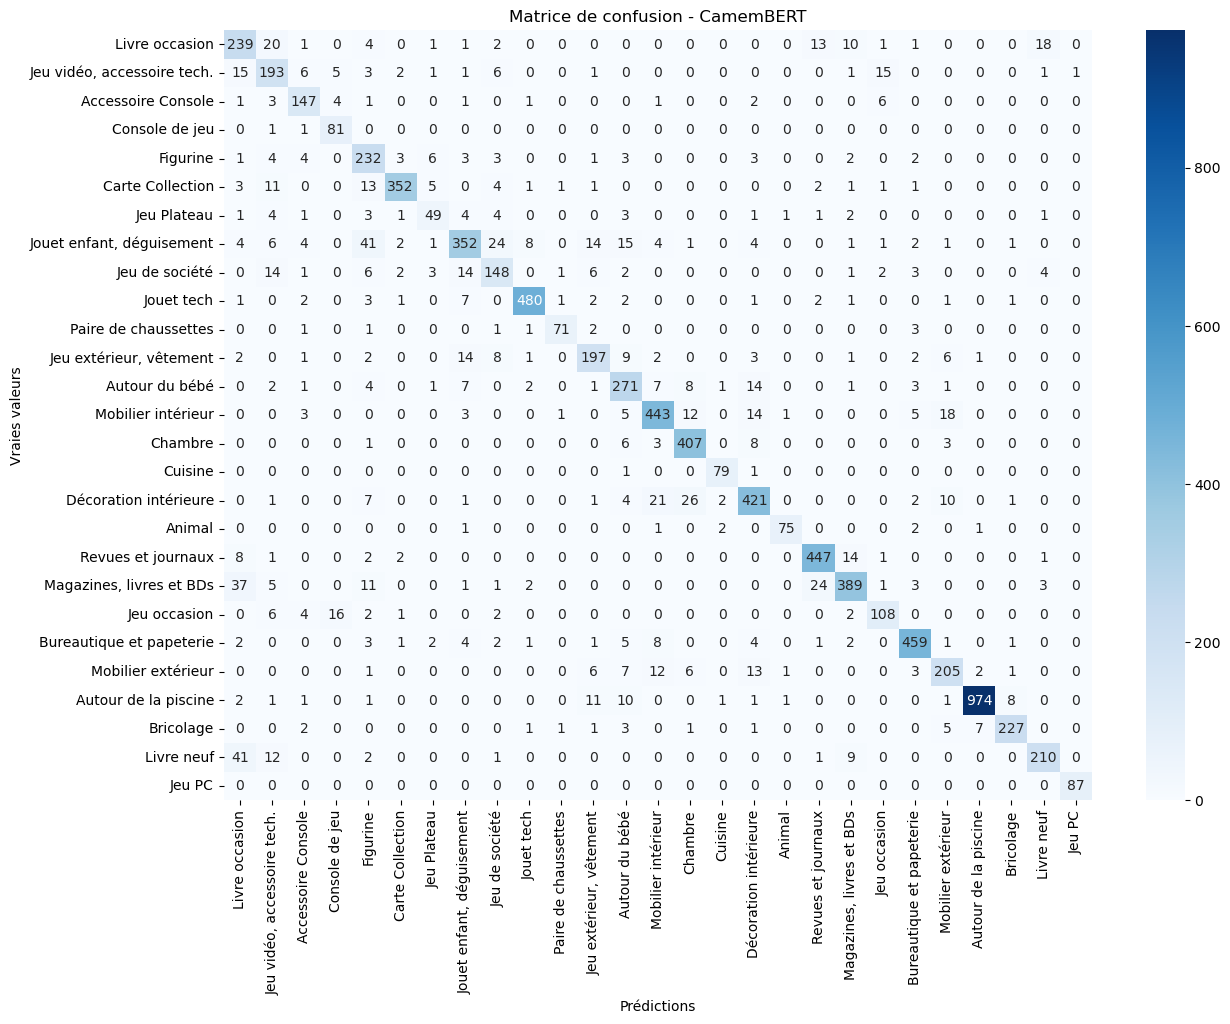

In [33]:
model_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\FINALE\Camembert\camembert_modele_7\camembert_lr5e-05_wd1e-03_ep5"

# Recharge du modèle et le tokenizer
model = CamembertForSequenceClassification.from_pretrained(model_path)
tokenizer = CamembertTokenizer.from_pretrained(model_path)

# Utilisation du GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Modèle chargé sur :", device)

# Prédictions avec le Trainer
trainer = Trainer(model=model)
predictions = trainer.predict(val_dataset)  
y_pred = predictions.predictions.argmax(axis=1)

# Récupération des vraies étiquettes
y_val_true = np.array(val_dataset["label"])

# Mapping des indices vers les vraies catégories
try:
    y_pred_labels = [inverse_label_mapping[pred] for pred in y_pred]
    y_val_labels = [inverse_label_mapping[true] for true in y_val_true]
except KeyError as e:
    print(f"Erreur : une étiquette ({e}) ne correspond pas à inverse_label_mapping.")
    raise

# F1-score pondéré
weighted_f1 = f1_score(y_val_labels, y_pred_labels, average="weighted")

# Affichage du rapport de classification
category_labels = list(labelcat.values()) if "labelcat" in globals() else sorted(set(y_val_labels))
print("\nÉvaluation sur le jeu de validation (X_val) :")
print(classification_report(y_val_labels, y_pred_labels, target_names=category_labels))
print(f"F1-score (pondéré) : {weighted_f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_val_labels, y_pred_labels)

# Affichage de la heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Matrice de confusion - CamemBERT")
plt.show()


# **Modele CNN BENCHMARK**

## Chargement des Données Préprocéssées

In [15]:
# Chargement des fichiers
X_train = pd.read_csv("./Preprocessing/dfs/X_train_fullpreprocessed.csv")
X_val = pd.read_csv("./Preprocessing/dfs/X_val_fullpreprocessed.csv")
X_test = pd.read_csv("./Preprocessing/dfs/X_test_fullpreprocessed.csv")

# Séparation des colonnes textuelles
X_train_0 = X_train["txt_0_tok_stp_lem"]  #Non traduit
X_train_fr = X_train["txt_fr_tok_stp_lem"]  #Traduit

X_val_0 = X_val["txt_0_tok_stp_lem"]
X_val_fr = X_val["txt_fr_tok_stp_lem"] 

X_test_0 = X_test["txt_0_tok_stp_lem"]
X_test_fr = X_test["txt_fr_tok_stp_lem"] 


# Labels (identiques pour les deux versions)
y_train = X_train["prdtypecode"]
y_val = X_val["prdtypecode"]
y_test = X_test["prdtypecode"]


## Création des Vocabulaires

In [16]:
# Construction du vocabulaire pour chaque colonne
all_texts_0 = pd.concat([X_train_0 , X_val_0, X_test_0]).dropna()
all_texts_fr = pd.concat([X_train_fr, X_val_fr, X_test_fr]).dropna()

# Création d'un dictionnaire mot -> index
word_index_0 = {word: i+1 for i, word in enumerate(set(" ".join(all_texts_0).split()))}
word_index_fr = {word: i+1 for i, word in enumerate(set(" ".join(all_texts_fr).split()))}


Le but de cette étape est de convertir les tokens textuels en indices numériques afin que le CNN puisse traiter les entrées. Voici notre demarche :
1. Les réseaux de neurones ne peuvent pas traiter du texte brut. Nous devons donc associer chaque mot unique à un numéro, ce qui sera comprehensible par le modele.

2. Chaque colonne de texte (txt_0 et txt_fr) peut avoir des vocabulaires différents. On construit donc un vocabulaire distinct pour chaque version du texte

3. On concatène toutes les données (X_train, X_val, X_test) pour éviter d’avoir des mots non vus lors du test.
Ainsi, chaque mot unique du dataset obtient toujours le même index, que ce soit en entraînement, validation ou test.

4. Le set() permet d'éliminer les mots dupliqués automatiquement. 

## Conversion des Textes en Séquences Numériques
On remplace les tokens par leurs indices directement avec des listes en compréhension.

In [17]:
# Conversion des tokens en indices
X_train_seq_0 = [[word_index_0[word] for word in text.split() if word in word_index_0] for text in X_train_0.dropna()]
X_val_seq_0 = [[word_index_0[word] for word in text.split() if word in word_index_0] for text in X_val_0.dropna()]
X_test_seq_0 = [[word_index_0[word] for word in text.split() if word in word_index_0] for text in X_test_0.dropna()]

X_train_seq_fr = [[word_index_fr[word] for word in text.split() if word in word_index_fr] for text in X_train_fr.dropna()]
X_val_seq_fr = [[word_index_fr[word] for word in text.split() if word in word_index_fr] for text in X_val_fr.dropna()]
X_test_seq_fr = [[word_index_fr[word] for word in text.split() if word in word_index_fr] for text in X_test_fr.dropna()]


## Appliquer le Padding
On applique directement le padding aux séquences.

In [18]:
MAX_LEN = 34  # Longueur maximale des séquences utilisée par le benchmark

# Padding des séquences pour chaque colonne
X_train_padded_0 = pad_sequences(X_train_seq_0, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_padded_0 = pad_sequences(X_val_seq_0, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_padded_0 = pad_sequences(X_test_seq_0, maxlen=MAX_LEN, padding="post", truncating="post")

X_train_padded_fr = pad_sequences(X_train_seq_fr, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_padded_fr = pad_sequences(X_val_seq_fr, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_padded_fr = pad_sequences(X_test_seq_fr, maxlen=MAX_LEN, padding="post", truncating="post")

X_train_padded_0 = np.where(X_train_padded_0 > 57734, 1, X_train_padded_0)
X_val_padded_0 = np.where(X_val_padded_0 > 57734, 1, X_val_padded_0)
X_test_padded_0 = np.where(X_test_padded_0 > 57734, 1, X_test_padded_0)

X_train_padded_fr = np.where(X_train_padded_fr > 57734, 1, X_train_padded_fr)
X_val_padded_fr = np.where(X_val_padded_fr > 57734, 1, X_val_padded_fr)
X_test_padded_fr = np.where(X_test_padded_fr > 57734, 1, X_test_padded_fr)


## Encodage des Labels

In [19]:
# Encodage des labels en entiers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Conversion en one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = tf.keras.utils.to_categorical(y_val_encoded, num_classes=num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)


##  Définition du Modèle CNN

In [20]:
# Définition de l'entrée
input_layer = Input(shape=(34,), dtype="int32")


max_vocab_size = 57735  # Taille cible pour obtenir 17,320,500 paramètres

# Vérifie que l'index des mots ne dépasse pas la limite
word_index_0_limited = {word: i+1 for i, word in enumerate(list(word_index_0.keys())[:max_vocab_size])}

# Correction de l'Embedding Layer
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=300, input_length=34)(input_layer)
reshape_layer = Reshape((34, 300, 1))(embedding_layer) 


#  Chaque Conv2D est maintenant correctement connecté à Reshape Layer
conv1 = Conv2D(filters=512, kernel_size=(1, 300), activation="relu")(reshape_layer)
pool1 = MaxPooling2D(pool_size=(34, 1))(conv1)  

conv2 = Conv2D(filters=512, kernel_size=(2, 300), activation="relu")(reshape_layer)
pool2 = MaxPooling2D(pool_size=(33, 1))(conv2)  

conv3 = Conv2D(filters=512, kernel_size=(3, 300), activation="relu")(reshape_layer)
pool3 = MaxPooling2D(pool_size=(32, 1))(conv3)  

conv4 = Conv2D(filters=512, kernel_size=(4, 300), activation="relu")(reshape_layer)
pool4 = MaxPooling2D(pool_size=(31, 1))(conv4)  

conv5 = Conv2D(filters=512, kernel_size=(5, 300), activation="relu")(reshape_layer)
pool5 = MaxPooling2D(pool_size=(30, 1))(conv5)  

conv6 = Conv2D(filters=512, kernel_size=(6, 300), activation="relu")(reshape_layer)
pool6 = MaxPooling2D(pool_size=(29, 1))(conv6)  


merged = Concatenate(axis=1)([pool1, pool2, pool3, pool4, pool5, pool6])



flatten = Flatten()(merged)
dropout = Dropout(0.5)(flatten)  # Dropout = 0.5 ici
output_layer = Dense(27, activation="softmax")(dropout)  # 27 classes

# Création et compilation du modèle
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Affichage du résumé du modèle
model.summary()


C:\Users\rudy_\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 34, 300)   │ 17,320,500 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 34, 300,   │          0 │ embedding_1[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 34, 1,     │    154,112 │ reshape_1[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 33, 1,     │    307,712 │ reshape_1[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 1,     │    461,312 │ reshape_1[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 31, 1,     │    614,912 │ reshape_1[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 30, 1,     │    768,512 │ reshape_1[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 29, 1,     │    922,112 │ reshape_1[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 1, 1, 512) │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 1, 1, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 1, 1, 512) │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 1, 1, 512) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 1, 1, 512) │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 1, 1, 512) │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 6, 1, 512) │          0 │ max_pooling2d_6[… │
│ (Concatenate)       │                   │            │ max_pooling2d_7[… │
│                     │                   │            │ max_pooling2d_8[… │
│                     │                   │            │ max_pooling2d_9[

 Total params: 20,632,143 (78.71 MB)

 Trainable params: 20,632,143 (78.71 MB)

 Non-trainable params: 0 (0.00 B)

## Entraînement du Modèle No Traduction

In [21]:
BATCH_SIZE = 64
EPOCHS = 5

history = model.fit(
    X_train_padded_0, y_train_onehot,
    validation_data=(X_val_padded_0, y_val_onehot),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

# Sauvegarde du modèle entraîné
os.makedirs("./Benchmark", exist_ok=True)
model.save("./Benchmark/CNN_no_trad.keras")

Epoch 1/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 806s 785ms/step - accuracy: 0.4121 - loss: 2.0402 - val_accuracy: 0.6137 - val_loss: 1.3046
Epoch 2/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 837s 816ms/step - accuracy: 0.6951 - loss: 1.0265 - val_accuracy: 0.6364 - val_loss: 1.2844
Epoch 3/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 802s 782ms/step - accuracy: 0.7930 - loss: 0.6849 - val_accuracy: 0.6319 - val_loss: 1.4208
Epoch 4/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 799s 779ms/step - accuracy: 0.8320 - loss: 0.5338 - val_accuracy: 0.6308 - val_loss: 1.5287
Epoch 5/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 817s 797ms/step - accuracy: 0.8542 - loss: 0.4671 - val_accuracy: 0.6269 - val_loss: 1.6929


## Évaluation du Modèle No Traduction

264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
Weighted F1-Score : 0.6298

Rapport de Classification :

                             precision    recall  f1-score   support

             Livre occasion       0.38      0.21      0.27       312
Jeu vidéo, accessoire tech.       0.60      0.49      0.54       249
         Accessoire Console       0.60      0.53      0.56       167
             Console de jeu       0.88      0.79      0.83        82
                   Figurine       0.62      0.43      0.51       267
           Carte Collection       0.69      0.66      0.68       395
                Jeu Plateau       0.51      0.49      0.50        77
  Jouet enfant, déguisement       0.46      0.45      0.46       485
             Jeu de société       0.48      0.21      0.29       207
                 Jouet tech       0.70      0.77      0.73       504
       Paire de chaussettes       0.86      0.75      0.80        79
    Jeu extérieur, vêtement       0.71      0.51      0.60       245
   

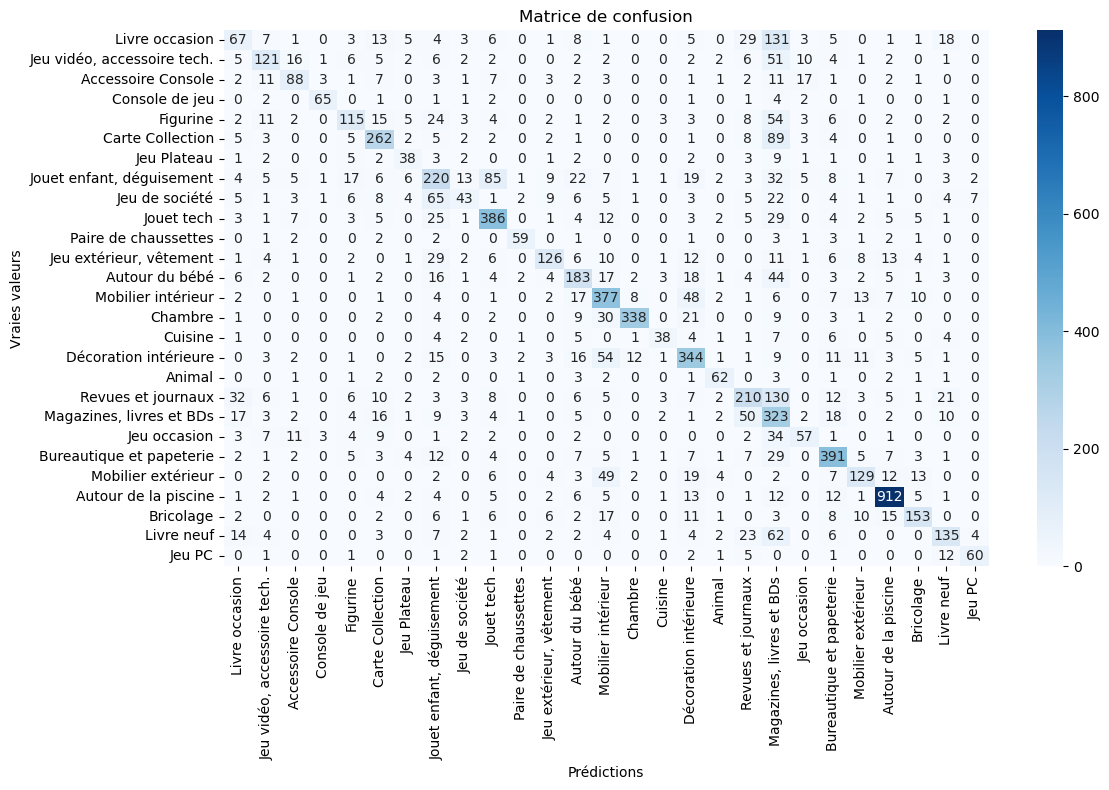

In [22]:
# Préparation des noms de classes pour l'évaluation
encoded_labels = label_encoder.classes_
target_names = [labelcat[int(code)] for code in encoded_labels]  # labelcat défini au debut du notebook

# Prédictions sur le jeu de test
y_pred_labels = model.predict(X_test_padded_0).argmax(axis=1)
y_true = np.argmax(y_test_onehot, axis=1) # Conversion des labels one-hot encodés en classes réelles

# Score F1 pondéré
weighted_f1 = f1_score(y_true, y_pred_labels, average='weighted')
print(f"Weighted F1-Score : {weighted_f1:.4f}")

# Rapport de classification
print("\nRapport de Classification :\n")
print(classification_report(y_test_encoded, y_pred_labels, target_names=target_names))

# Matrice de confusion
cm = confusion_matrix(y_test_encoded, y_pred_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Entraînement du Modèle Traduction fr

In [10]:
BATCH_SIZE = 64
EPOCHS = 5

history = model.fit(
    X_train_padded_fr, y_train_onehot,
    validation_data=(X_val_padded_fr, y_val_onehot),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

# Sauvegarde du modèle entraîné
os.makedirs("./Benchmark", exist_ok=True)
model.save("./Benchmark/CNN_fr.keras")

Epoch 1/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 812s 790ms/step - accuracy: 0.4252 - loss: 1.9845 - val_accuracy: 0.6262 - val_loss: 1.2288
Epoch 2/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 797s 777ms/step - accuracy: 0.6979 - loss: 1.0028 - val_accuracy: 0.6423 - val_loss: 1.2194
Epoch 3/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 802s 782ms/step - accuracy: 0.8031 - loss: 0.6412 - val_accuracy: 0.6344 - val_loss: 1.3456
Epoch 4/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 794s 775ms/step - accuracy: 0.8392 - loss: 0.5022 - val_accuracy: 0.6344 - val_loss: 1.5153
Epoch 5/5
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 799s 779ms/step - accuracy: 0.8565 - loss: 0.4470 - val_accuracy: 0.6356 - val_loss: 1.6375


## Évaluation du Modèle Traduction FR

264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
Weighted F1-Score : 0.6279

Rapport de Classification :

                             precision    recall  f1-score   support

             Livre occasion       0.24      0.29      0.26       312
Jeu vidéo, accessoire tech.       0.53      0.51      0.52       249
         Accessoire Console       0.66      0.57      0.61       167
             Console de jeu       0.65      0.85      0.74        82
                   Figurine       0.45      0.36      0.40       267
           Carte Collection       0.51      0.77      0.62       395
                Jeu Plateau       0.46      0.35      0.40        77
  Jouet enfant, déguisement       0.47      0.40      0.43       485
             Jeu de société       0.41      0.35      0.38       207
                 Jouet tech       0.73      0.78      0.75       504
       Paire de chaussettes       0.85      0.77      0.81        79
    Jeu extérieur, vêtement       0.77      0.57      0.66       245
   

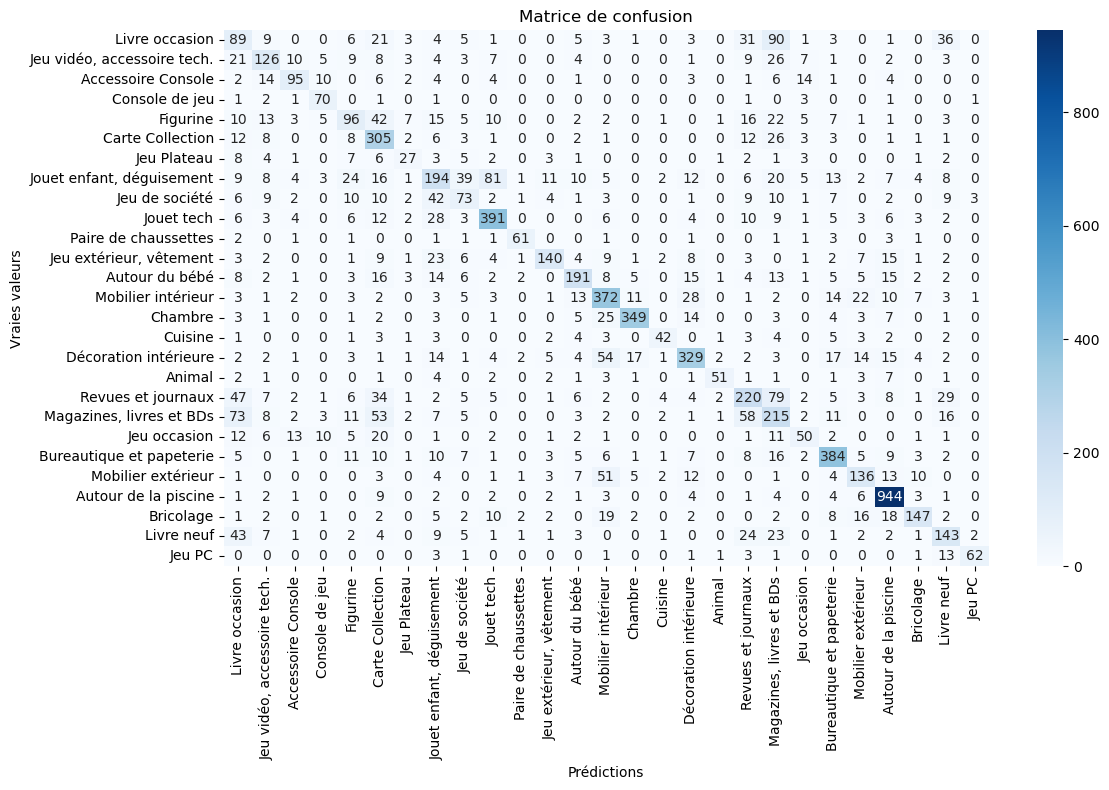

In [14]:
# Préparation des noms de classes pour l'évaluation
encoded_labels = label_encoder.classes_
target_names = [labelcat[int(code)] for code in encoded_labels]  # labelcat défini au debut du notebook

# Prédictions sur le jeu de test
y_pred_labels = model.predict(X_test_padded_fr).argmax(axis=1)
y_true = np.argmax(y_test_onehot, axis=1) # Conversion des labels one-hot encodés en classes réelles

# Score F1 pondéré
weighted_f1 = f1_score(y_true, y_pred_labels, average='weighted')
print(f"Weighted F1-Score : {weighted_f1:.4f}")

# Rapport de classification
print("\nRapport de Classification :\n")
print(classification_report(y_test_encoded, y_pred_labels, target_names=target_names))

# Matrice de confusion
cm = confusion_matrix(y_test_encoded, y_pred_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()